In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from itertools import cycle
from functools import partial
from glob import glob

sys.path.append('../../')
from hamp_pred.utils.measure import measure_one_HAMP, average_angles, get_ref_crick
from hamp_pred.utils.tools import diffangle

from hamp_pred.src.input_prep.encode import radius, phobos

sys.path.append('/home/nfs/sdunin/scr/localpdb')
# get localpdb from https://github.com/labstructbioinf/localpdb
from localpdb import PDB


In [2]:
# version 20220902 enforcecd because PDBSeqresMapper plugin was not correctly updated to 2024 version

lpdb = PDB('/home/db/localpdb', plugins=['PDBSeqresMapper'], version=20220902)

In [3]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning
warnings.filterwarnings(action='ignore', category=PDBConstructionWarning, module='Bio')
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [4]:
data_dir = '../../data/input'

crangles = {'a':19.5,'b':122.35,'c':-134.78,'d': -31.92,'e':70.92 ,'f':173.78,'g':-83.35}

AA_3_to_1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


In [5]:
#207+12

In [9]:
exp_hamps = [
    
    # HAMP Af1503
    ['2l7h.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 WT', False],    # OK
    ['2l7i.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291F', False], # OK
    ['2y0q.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291C', False], # OK
    ['2y20.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291I', False], # OK
    ['2y21.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291V', False], # OK
    ['4gn0.pdb', 253, 281, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 WT', False],    # OK
    ['4cq4.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 WT', False],    # OK
    
    # 2Y0T assymetric
    
    # NarQ
    ['5iji.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', False], # OK
    ['5jeq.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', True], # missing residues 
    ['5jef.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', False], # OK
    ['5jgp.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', False], # OK
    ['6yue.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', '', False], # OK
        
    # HAMP-DhP
    ['3zrx.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291F+DHp(EnvZ)', False],    # OK
    ['3zrv.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291F+DHp(EnvZ)', False],    # OK
    ['3zrw.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291V+DHp(EnvZ)', False],    # OK
    ['3zcc.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 WT+DHp(EnvZ)R333G ', False], # OK
    ['2lfr.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 WT+DHp(EnvZ)', False],       # OK  
    ['2lfs.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291F+DHp(EnvZ)', False],    # OK
    ['4cti.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', 'Af1503 A291F+DHp(EnvZ)', False],    # OK 
    
    ['4biv.pdb', 189, 217, 13, 'A', 'B', 'a', 'lightgrey', 'CpxA', False],               # OK
    ['3zx6.pdb', 7, 35, 13, 'A', 'B', 'a', 'lightgrey', 'AF1503 A291V+MA(Tsr)', False],  # OK
    
    ['4i5s.pdb', 40, 67, 13, 'A', 'B', 'a', 'lightgrey', 'VicK',   False], # VicK
    
    ['4i3m.pdb', 13, 40, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_1_m1', False],  # OK 
    ['4i3m.pdb', 68, 96, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_2_m1', False],  # OK 
    ['4i3m.pdb', 114, 140, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_3_m1',False], # OK
    
    ['3lnr.pdb', 13, 40, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_1', False],  # OK 
    ['3lnr.pdb', 68, 96, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_2', False],  # OK 
    ['3lnr.pdb', 114, 140, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_3',False], # OK
    
    ['4i44.pdb', 13, 40, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_1_m2', False],  # OK 
    ['4i44.pdb', 68, 96, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_2_m2', False],  # OK 
    ['4i44.pdb', 114, 140, 13, 'A', 'B', 'a', 'lightgrey', 'Aer2_3_m2',False], # OK
 
    ['4biu.pdb', 189, 217, 13, 'A', 'B', 'a', 'lightgrey', 'CpxA', False], # OK
    
    ['f6_AB.pdb', 30, 57, 13, 'A', 'B', 'a', 'lightgrey', 'MXAN_1', False], 
    ['f6_AB.pdb', 75, 104, 13, 'A', 'B', 'a', 'lightgrey', 'MXAN_2', False], # Af2 can't model this isolated HAMP
    ['f6_AB.pdb', 122, 154, 13, 'A', 'B', 'a', 'lightgrey', 'MXAN_3', False], 
    ['f6_AB.pdb', 172, 201, 13, 'A', 'B', 'a', 'lightgrey', 'MXAN_4', False], 
    ['f6_AB.pdb', 219, 246, 13, 'A', 'B', 'a', 'lightgrey', 'MXAN_5', False], 
    
    
    
]

exp_hamp2name = {str(n)+"_"+e[0]:e[-2] for n, e in enumerate(exp_hamps)}
exp_hamp2name

{'0_2l7h.pdb': 'Af1503 WT',
 '1_2l7i.pdb': 'Af1503 A291F',
 '2_2y0q.pdb': 'Af1503 A291C',
 '3_2y20.pdb': 'Af1503 A291I',
 '4_2y21.pdb': 'Af1503 A291V',
 '5_4gn0.pdb': 'Af1503 WT',
 '6_4cq4.pdb': 'Af1503 WT',
 '7_5iji.pdb': '',
 '8_5jeq.pdb': '',
 '9_5jef.pdb': '',
 '10_5jgp.pdb': '',
 '11_6yue.pdb': '',
 '12_3zrx.pdb': 'Af1503 A291F+DHp(EnvZ)',
 '13_3zrv.pdb': 'Af1503 A291F+DHp(EnvZ)',
 '14_3zrw.pdb': 'Af1503 A291V+DHp(EnvZ)',
 '15_3zcc.pdb': 'Af1503 WT+DHp(EnvZ)R333G ',
 '16_2lfr.pdb': 'Af1503 WT+DHp(EnvZ)',
 '17_2lfs.pdb': 'Af1503 A291F+DHp(EnvZ)',
 '18_4cti.pdb': 'Af1503 A291F+DHp(EnvZ)',
 '19_4biv.pdb': 'CpxA',
 '20_3zx6.pdb': 'AF1503 A291V+MA(Tsr)',
 '21_4i5s.pdb': 'VicK',
 '22_4i3m.pdb': 'Aer2_1_m1',
 '23_4i3m.pdb': 'Aer2_2_m1',
 '24_4i3m.pdb': 'Aer2_3_m1',
 '25_3lnr.pdb': 'Aer2_1',
 '26_3lnr.pdb': 'Aer2_2',
 '27_3lnr.pdb': 'Aer2_3',
 '28_4i44.pdb': 'Aer2_1_m2',
 '29_4i44.pdb': 'Aer2_2_m2',
 '30_4i44.pdb': 'Aer2_3_m2',
 '31_4biu.pdb': 'CpxA',
 '32_f6_AB.pdb': 'MXAN_1',
 '33_f6_AB

### Prepare AF2 jobs for the experimental structures

In [28]:
MXAN_SHIFT = 26 # shift between the sequence and pdb numbering

# full sequence of the mxan construct
mxan_seq = """SQSLDSRQLLRVLTAVRKGDFSVRMPVDKVGSAGKVADTLNEIIELSERMAREFERIGNVVGKEGRITQR
GNVVGALGSWGDCVESVNMLVADLVQPTTEMGRVIGAVAKGDLSQTMALEVDGRPLRGEFLRTARLVNGM
VEQLGAFASEVTRVAREVGTDGKLGGQAKVKGVAGTWKDLTDNVNSMASNLTAQVRSIAEVTTAVAKGDL
SKKITVDVRGEILELKNTINTMVDQLNSFASEVTRQSLDSRQLLRVLTAVRKGDFSVRMPVDKVGSAGKV
ADTLNEIIELSERMAREFERIGNVVGKEGRITQRGNVVGALGSWGDCVESVNMLVADLVQPTTEMGRVIG
AVAKGDLSQTMALEVDGRPLRGEFLRTARLVNGMVEQLGAFASEVTRVAREVGTDGKLGGQAKVKGVAGT
WKDLTDNVNSMASNLTAQVRSIAEVTTAVAKGDLSKKITVDVRGEILELKNTINTMVDQLNSFASEVTRV""".replace('\n', '')


In [29]:
#ok_sequences = []

# files available upon request
af2_path = '/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15' # 5 recycles / ColabFold 1.5
EXTENSION = 3 # how many aa to add at the N/C ends

helices = []

for pos, row in enumerate(exp_hamps):
    pdb, pdb_startN, pdb_startC, length, chain_A, chain_B, heptad, color, name, mutant = row
    pdb = pdb.split('.')[0]
    
    # regular PDB structures
    if pos<=31:
        # get HAMP sequence with the linker 
        pdb_chain = f'{pdb.lower()}_{chain_A.upper()}'
        chain_seq = lpdb.chains.loc[pdb_chain].sequence
        chain_mapping = lpdb.get_pdbseqres_mapping(pdb_chain)
        inv_chain_mapping = {v: k for k, v in chain_mapping.items()}

        seq_startN = chain_mapping[str(pdb_startN)]
        seq_startC = chain_mapping[str(pdb_startC)]

        n_helix = chain_seq[seq_startN:seq_startN+length]
        c_helix = chain_seq[seq_startC:seq_startC+length]

        # sequence redundancy check
        #if not mutant:
        #    full_seq = n_helix + c_helix
        #    assert full_seq not in ok_sequences, pdb
        #    ok_sequences.append(full_seq)

        # debug
        # pdb, seq_startN, n_helix, seq_startN+len-1, seq_startC
        #if row[-1] == False:
        #    print(inv_chain_mapping[seq_startC+length-1])

        full_seq = chain_seq[seq_startN-EXTENSION:seq_startC+length+EXTENSION]
        
    # MXAN HAMPs (not in PDB)
    else:
        
        #print(pdb, pdb_startN, pdb_startC, length, chain_A, chain_B, heptad, color, name, mutant)
        
        
        n_helix = mxan_seq[pdb_startN-MXAN_SHIFT:pdb_startN-MXAN_SHIFT+length]
        c_helix = mxan_seq[pdb_startC-MXAN_SHIFT:pdb_startC-MXAN_SHIFT+length]
        
        full_seq = mxan_seq[pdb_startN-MXAN_SHIFT-EXTENSION:pdb_startC-MXAN_SHIFT+length+EXTENSION]
        
    
    print ('\t'.join([pdb, n_helix, c_helix, full_seq]))
    #continue
    
    helices.append([n_helix, c_helix, full_seq])
    
    # create job's path
    path = os.path.join(af2_path, f'{pos}_{pdb}')
    try:
        os.makedirs(path)
    except FileExistsError:
        continue
    
    # write slurm config
    txt='''#!/bin/bash
#SBATCH -p gpu
#SBATCH -n 1
#SBATCH --exclude=edi00
#SBATCH --gres=gpu:1
#SBATCH --mem=20GB
#SBATCH -J HAMP
source /opt/miniconda3/bin/activate cf_1.5
export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
colabfold_batch query.csv . --num-recycle 5'''
    
    f = open(os.path.join(path, 'job.sh'), 'wt')
    f.write(txt)
    f.close()
    
    # write colabfold input
    txt = f'''id,sequence
model,{full_seq}:{full_seq}'''
    
    f = open(os.path.join(path, 'query.csv'), 'wt')
    f.write(txt)
    f.close()    
    
        

2l7h	PIIELSNTADKIA	EIGILAKSIERLR	ITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSL
2l7i	PIIELSNTFDKIA	EIGILAKSIERLR	ITRPIIELSNTFDKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSL
2y0q	PIIELSNTCDKIA	EIGILAKSIERLR	ITRPIIELSNTCDKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSL
2y20	PIIELSNTIDKIA	EIGILAKSIERLR	ITRPIIELSNTIDKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSL
2y21	PIIELSNTVDKIA	EIGILAKSIERLR	ITRPIIELSNTVDKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSL
4gn0	PIIELSNTADKIA	EIGILAKSIERLR	ITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSL
4cq4	PIIELSNTADKIA	EIGILAKSIERLR	ITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSL
5iji	PLNQLVTASQRIE	ELGLLAKTFNQMS	VVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQMSSEL
5jeq	PLNQLVTASQRIE	ELGLLAKTFNQMS	VVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQMSSEL
5jef	PLNQLVTASQRIE	ELGLLAKTFNQMS	VVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQMSSEL
5jgp	PLNQLVTASQRIE	ELGLLAKTFNQMS	VVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQMSSEL
6yue	PLNQLVTASQRIE	ELGLLAKTFNQMS	VVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQMSSEL
3zrx	PIIELSNTFDKIA	EIGILAKSI

### Measure AF2 models 
Models are unrelaxed

/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/0_2l7h/model_unrelaxed_rank_001_alphafold2_multimer_v3_model_5_seed_000.pdb
/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/1_2l7i/model_unrelaxed_rank_001_alphafold2_multimer_v3_model_5_seed_000.pdb
/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/2_2y0q/model_unrelaxed_rank_001_alphafold2_multimer_v3_model_5_seed_000.pdb
/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/3_2y20/model_unrelaxed_rank_001_alphafold2_multimer_v3_model_4_seed_000.pdb
/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/4_2y21/model_unrelaxed_rank_001_alphafold2_multimer_v3_model_4_seed_000.pdb
/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/5_4gn0/model_unrelaxed_rank_001_alphafold2_multimer_v3_model_5_seed_000.pdb
/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/6_4cq4/model_unrelaxed_rank_001_alphafold2_multimer_v3_model_5_seed_000.pdb
/home/nfs/sdunin/calc/HAMP/experimental_af2_5_CF15/7_5iji/model_unrelaxed_rank_001_alphafold2_multimer_v3_model

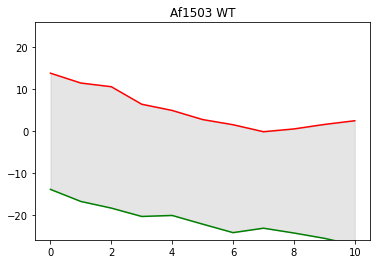

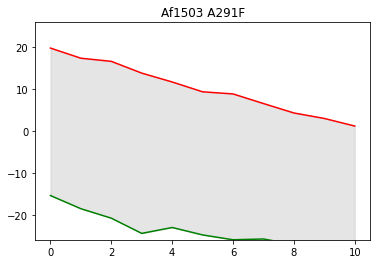

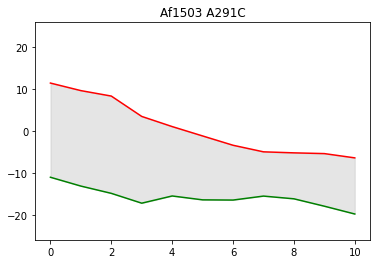

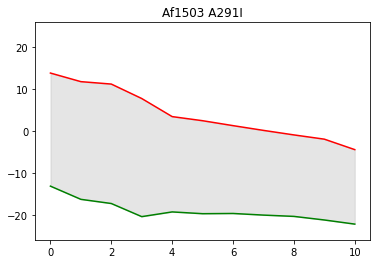

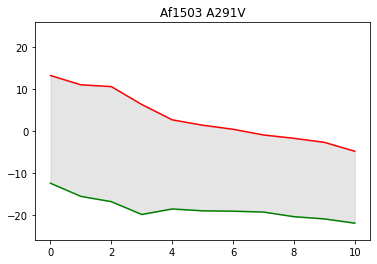

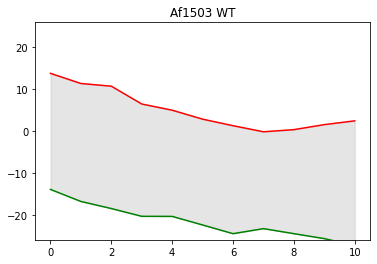

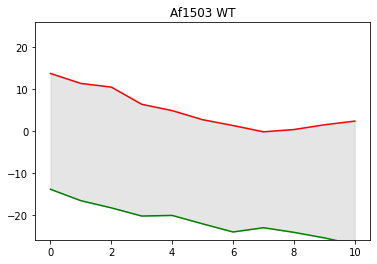

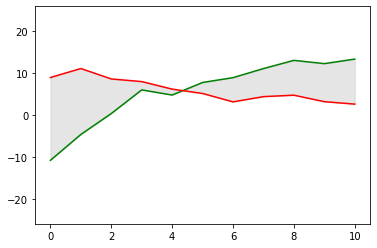

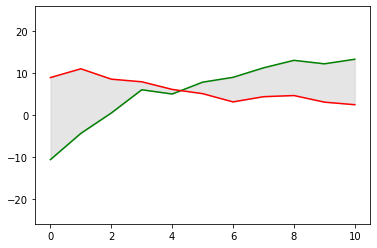

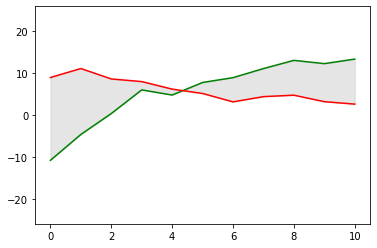

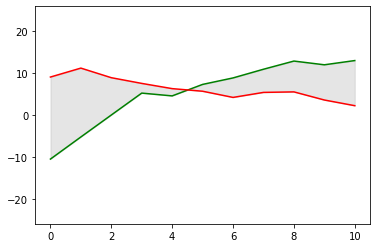

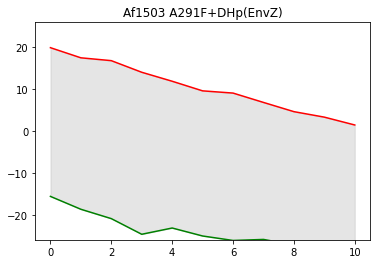

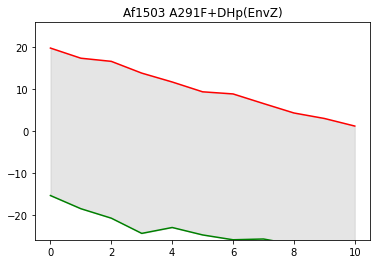

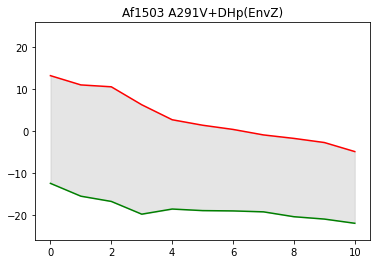

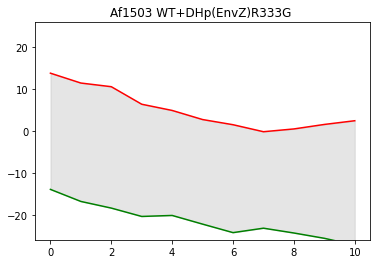

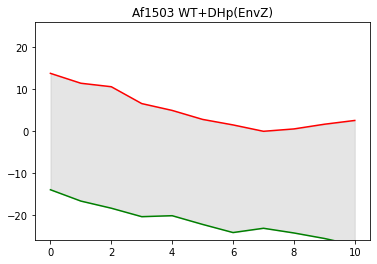

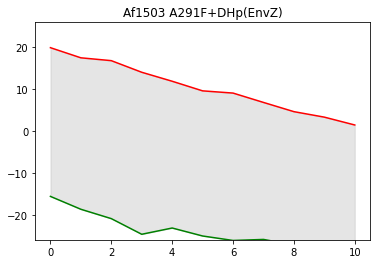

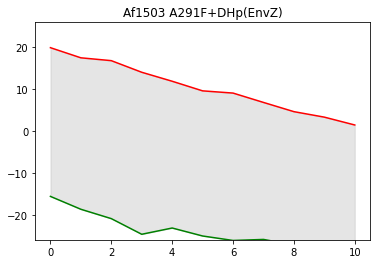

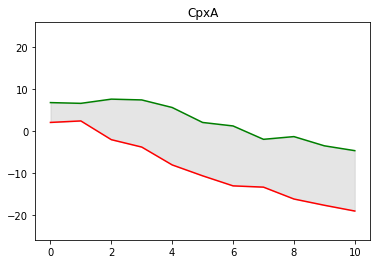

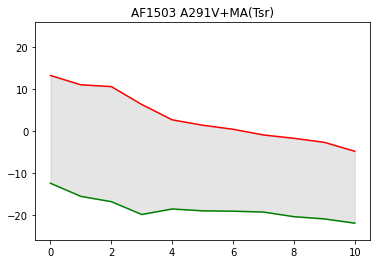

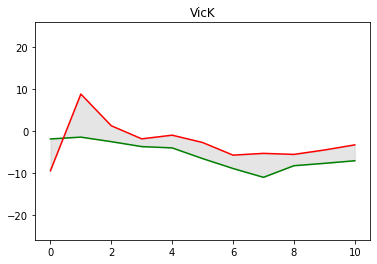

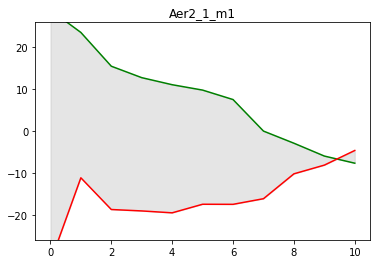

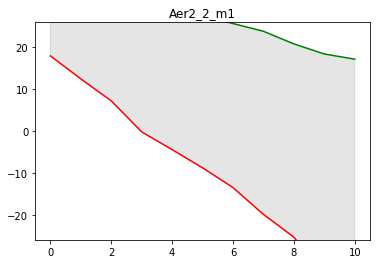

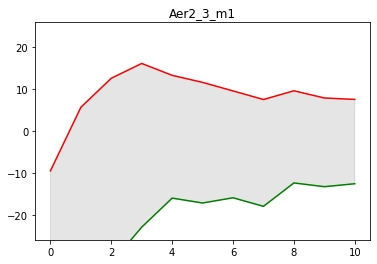

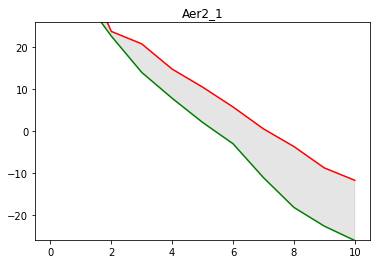

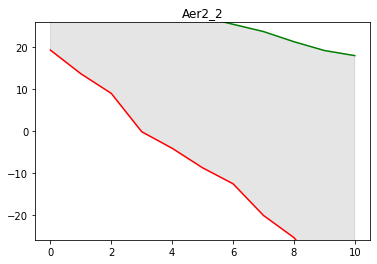

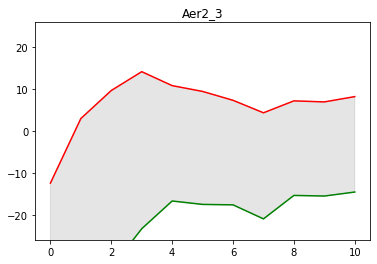

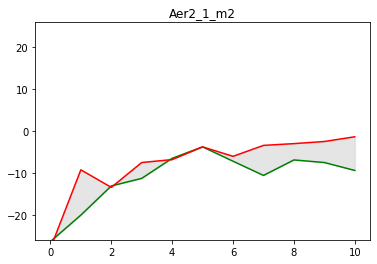

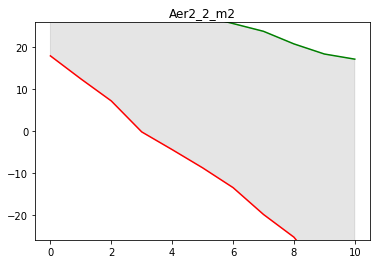

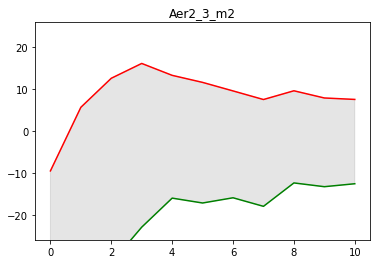

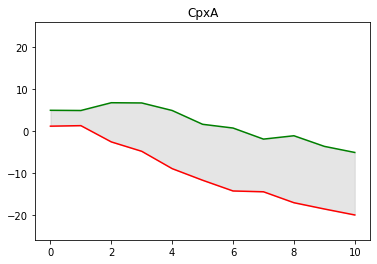

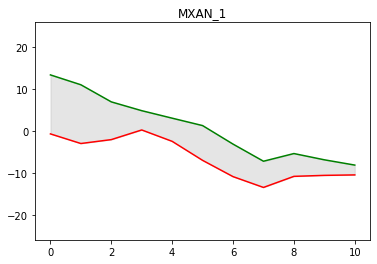

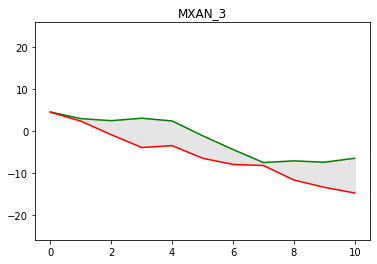

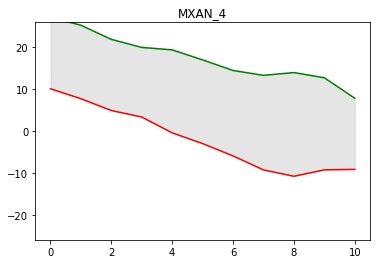

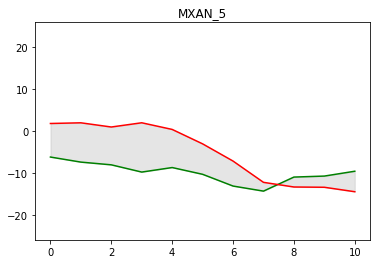

In [30]:
data=[]

for pos, (exp_hamp, helix) in enumerate(zip(exp_hamps, helices)):
    
    if exp_hamp[-1]==True: continue
        
    pdb = exp_hamp[0].split('.')[0]
    n_helix_seq = helix[0]
    c_helix_seq = helix[1]
    full_seq = helix[2]
    name = exp_hamp[-2]
    
    # debug
    #if name != "Aer2_3_m1": continue
    
    assert full_seq.find(n_helix_seq) == EXTENSION
    
    # get pdb ranges        
    h1_start = EXTENSION
    h2_start = full_seq.find(c_helix_seq)
    
    a1_start, a1_stop = h1_start+1, h1_start+len(n_helix_seq)+1
    a2_start, a2_stop = h2_start+1, h2_start+len(c_helix_seq)+1
    chain1, chain2 = 'A', 'B'
    
    kwargs = {'a1_start':a1_start, 
              'a1_stop':a1_stop,
              'a2_start':a2_start,
              'a2_stop':a2_stop,
              'chain1':chain1,
              'chain2':chain2}
    
    # get 1 rank af2 model
    path = os.path.join(af2_path, f'{pos}_{pdb}')
    
    pdb_files = sorted(
        glob(os.path.join(path, '*_unrelaxed*.pdb')), 
        key=lambda x:int(x.split('/')[-1].split("_")[3])
    )
    
    assert len(pdb_files)>0, 'Missing models'
    pdb_file = pdb_files[0]
    
    print(pdb_file)
    
    # measure
    bundle_df, n_crick, c_crick = measure_one_HAMP(pdb_file,
                                                 a1_start, a1_stop,
                                                 a2_start, a2_stop,
                                                 chain1, chain2)

    # axial shift
    n_shift = bundle_df['shift'][0::2].mean()
    c_shift = bundle_df['shift'][1::2].mean()
    
    #print(n_shift, c_shift)
    
    glob_shift = (n_shift - c_shift) / 2
    
    
    # axial rotation
    
    n_crick = n_crick[2:-2]
    c_crick = c_crick[2:-2]
    
    #print(n_crick)
    #print(c_crick)
    
    P = bundle_df.P.values
    n_P_list = P[0::2][2:-2]
    c_P_list = P[1::2][2:-2]
        
    r = bundle_df.P.values
    n_r_list = r[0::2][2:-2]
    c_r_list = r[1::2][2:-2]
        
    n_P = c_P = 3.5
     
    c_phi = n_phi = crangles[exp_hamp[6]] 
    
    n_crick_ref = get_ref_crick(n_P, n_phi)[:len(n_crick)]
    c_crick_ref = get_ref_crick(c_P, c_phi)[:len(c_crick)]
        
    n_crick_diff = diffangle(n_crick, n_crick_ref)
    n_crick_diff = (n_crick_diff[0::2] + n_crick_diff[1::2])/2
    
    c_crick_diff = diffangle(c_crick, c_crick_ref)
    c_crick_diff = (c_crick_diff[0::2] + c_crick_diff[1::2])/2
    
    # there is a problem with this structure 
    # one layer is not measured properly in C-term helices
    # thus values are copied from the N-term helices
    if name == "Aer2_1_m2":
        c_crick_diff[5] = n_crick_diff[5]
        
    rot = diffangle(n_crick, c_crick) / 2
    rot = (rot[0::2] + rot[1::2])/2
    
    #print(exp_hamp[0], rot.mean())
    
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    ax.plot(n_crick_diff, label=exp_hamp[0]+"_N", color='green')
    ax.plot(c_crick_diff, label=exp_hamp[0]+"_C", color='red')
    
    ax.fill_between(range(len(n_crick_diff)), n_crick_diff, c_crick_diff,
                   color='k', alpha=0.1)
    
    #ax.plot(rot, label=exp_hamp[0]+"rotation", color='black')
    ax.set_ylim(-26, 26)
    ax.set_title(name)
        
    n_crick_diff = np.mean(n_crick_diff)
    c_crick_diff = np.mean(c_crick_diff)
            
    seq1 = bundle_df.res_name[0::4].tolist()
    seq2 = bundle_df.res_name[1::4].tolist()
    seq1 = "".join([AA_3_to_1[res] for res in seq1])
    seq2 = "".join([AA_3_to_1[res] for res in seq2])
    
    assert seq1 == n_helix_seq
    assert seq2 == c_helix_seq
    
    data.append([str(pos)+ "_" + exp_hamp[0], n_crick_diff, c_crick_diff, seq1, seq2, exp_hamp[7], n_crick, c_crick, exp_hamp[8],
                exp_hamp[9], glob_shift])
    
    
data_af2_df = pd.DataFrame(data, columns=['pdb', 'n_rot', 'c_rot', 'seq1', 'seq2', 'color', 'n_list', 'c_list', 'label', 'mutant', 'glob_shift'])
data_af2_df.set_index('pdb', inplace=True)

data_af2_df['rot'] = diffangle(data_af2_df.n_list, data_af2_df.c_list) 
data_af2_df['rot_mean'] = data_af2_df['rot'].apply(np.mean)
data_af2_df['rot_std'] = data_af2_df['rot'].apply(np.std)

data_af2_df.to_pickle(os.path.join(data_dir, 'pdb_af2_measure.p'))


In [31]:
len(data_af2_df)

35

In [32]:
data_af2_df

,n_rot,c_rot,seq1,seq2,color,n_list,c_list,label,mutant,glob_shift,rot,rot_mean,rot_std
pdb,,,,,,,,,,,,,
0_2l7h.pdb,-21.529045,5.092738,PIIELSNTADKIA,EIGILAKSIERLR,lightgrey,"[5.53529131665289, 5.5774569222749255, 105.644...","[33.31061949478797, 33.386997673455696, 133.74...",Af1503 WT,False,-0.153302,"[-27.775328178135084, -27.809540751180776, -28...",-26.621783,1.941892
1_2l7i.pdb,-24.222801,10.272667,PIIELSNTFDKIA,EIGILAKSIERLR,lightgrey,"[4.049107488140447, 4.124495601040022, 103.854...","[39.41146314744306, 39.29979958565775, 139.801...",Af1503 A291F,False,0.124457,"[-35.36235565930261, -35.17530398461773, -35.9...",-34.495468,2.144602
2_2y0q.pdb,-15.847365,0.692440,PIIELSNTCDKIA,EIGILAKSIERLR,lightgrey,"[8.497703311225834, 8.416373674309822, 109.318...","[30.834844294993452, 31.134071087129172, 131.9...",Af1503 A291C,False,0.155005,"[-22.337140983767625, -22.717697412819348, -22...",-16.539805,4.705483
3_2y20.pdb,-19.096381,4.079344,PIIELSNTIDKIA,EIGILAKSIERLR,lightgrey,"[6.345465067107552, 6.319599264354219, 106.076...","[33.36803793088546, 33.39087399467798, 134.123...",Af1503 A291I,False,0.149689,"[-27.022572863777896, -27.07127473032375, -28....",-23.175725,3.883660
4_2y21.pdb,-18.600803,3.249397,PIIELSNTVDKIA,EIGILAKSIERLR,lightgrey,"[7.082516290381529, 6.9761166495827265, 106.82...","[32.74507673585852, 32.83561402804052, 133.386...",Af1503 A291V,False,0.125477,"[-25.662560445477, -25.859497378457775, -26.56...",-21.850200,3.734467
5_4gn0.pdb,-21.640177,5.066149,PIIELSNTADKIA,EIGILAKSIERLR,lightgrey,"[5.621368304724397, 5.476611212517912, 105.630...","[33.296805118307965, 33.32775252898756, 133.75...",Af1503 WT,False,-0.158091,"[-27.67543681358356, -27.851141316469636, -28....",-26.706326,1.916726
6_4cq4.pdb,-21.429919,5.011525,PIIELSNTADKIA,EIGILAKSIERLR,lightgrey,"[5.673475542901207, 5.490753358461269, 105.832...","[33.3130876345789, 33.24894766110968, 133.7243...",Af1503 WT,False,-0.149523,"[-27.63961209167769, -27.758194302648405, -27....",-26.441444,1.934244
7_5iji.pdb,5.672385,6.027462,PLNQLVTASQRIE,ELGLLAKTFNQMS,lightgrey,"[8.766999758887389, 8.60436395996121, 117.7361...","[28.344831715457776, 28.62538928016778, 133.39...",,False,-1.312000,"[-19.57783195657038, -20.021025320206576, -15....",-0.355077,9.852967
9_5jef.pdb,5.771501,5.971827,PLNQLVTASQRIE,ELGLLAKTFNQMS,lightgrey,"[9.0171724960917, 8.679781614064426, 118.20668...","[28.484361027726077, 28.459101034488576, 133.4...",,False,-1.311956,"[-19.467188531634378, -19.779319420424144, -15...",-0.200326,9.801896


### Measure experimental structures

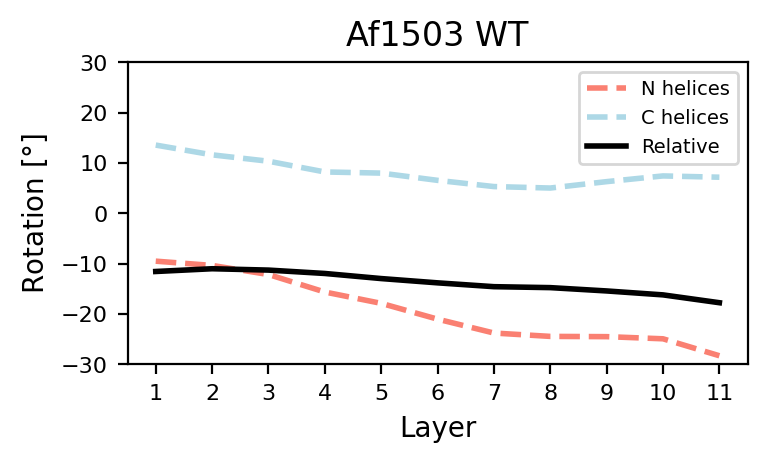

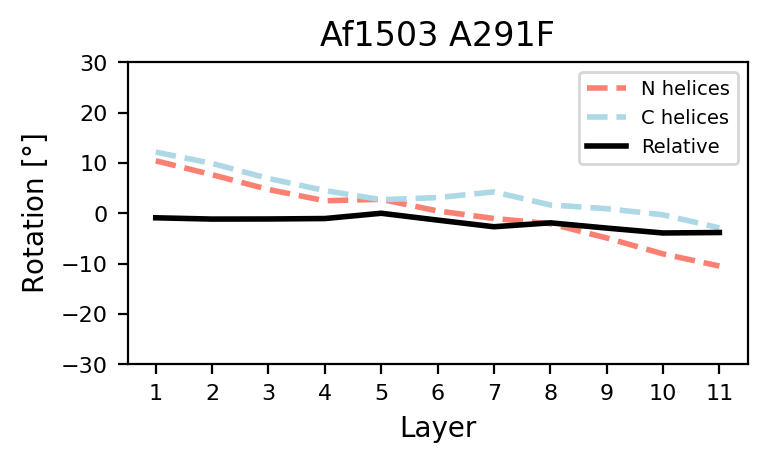

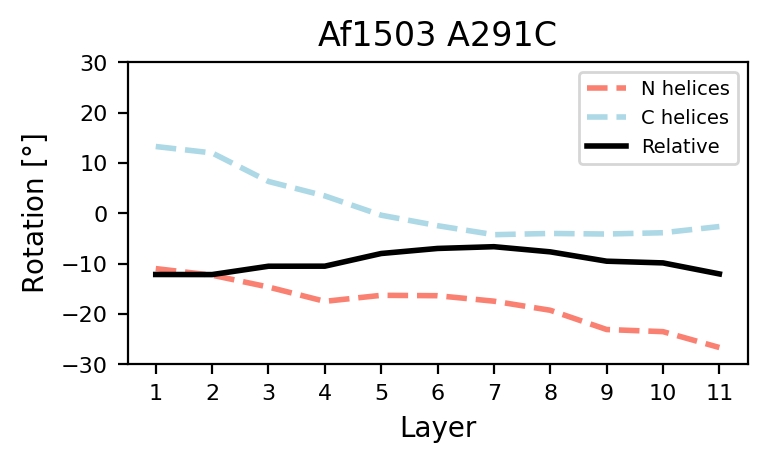

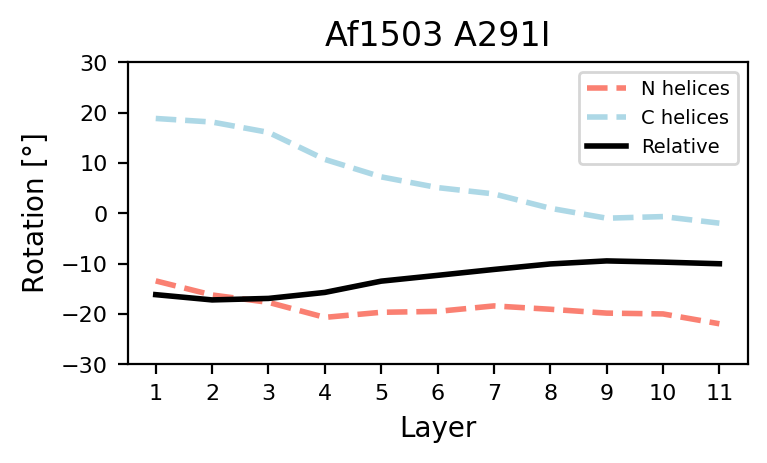

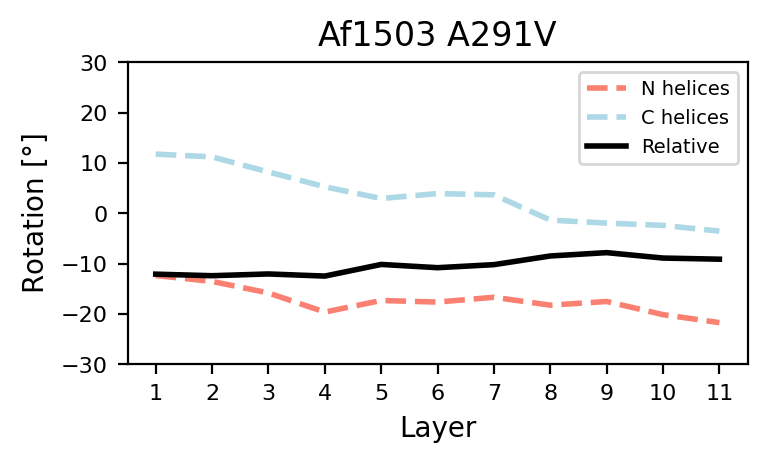

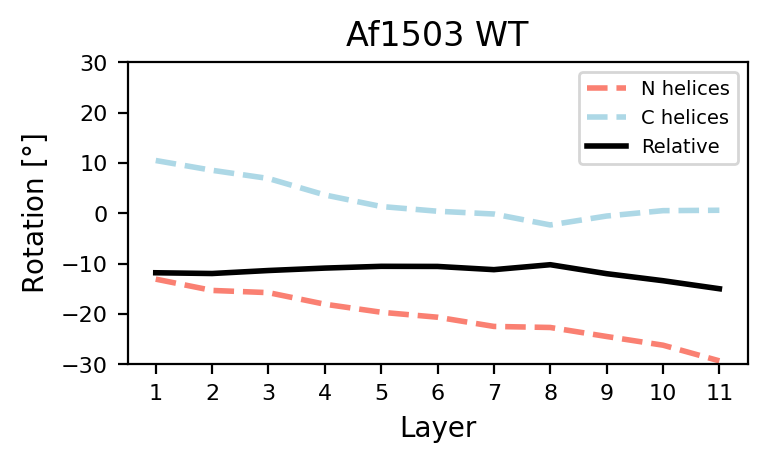

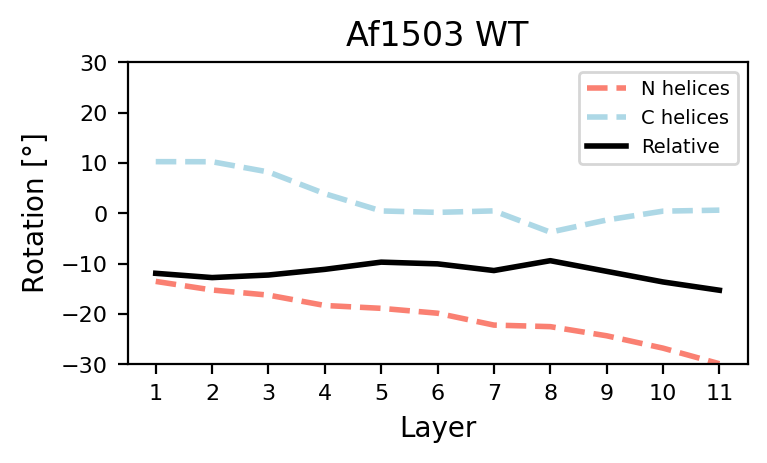

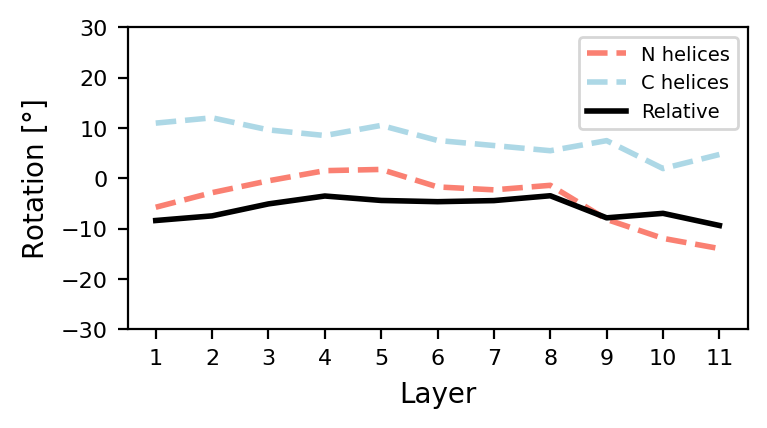

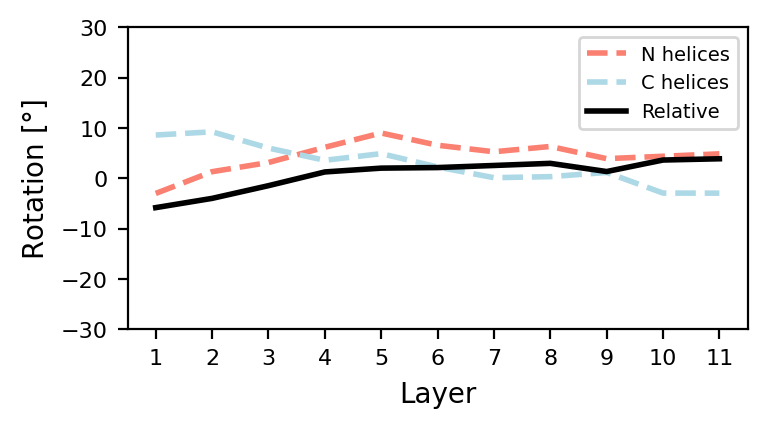

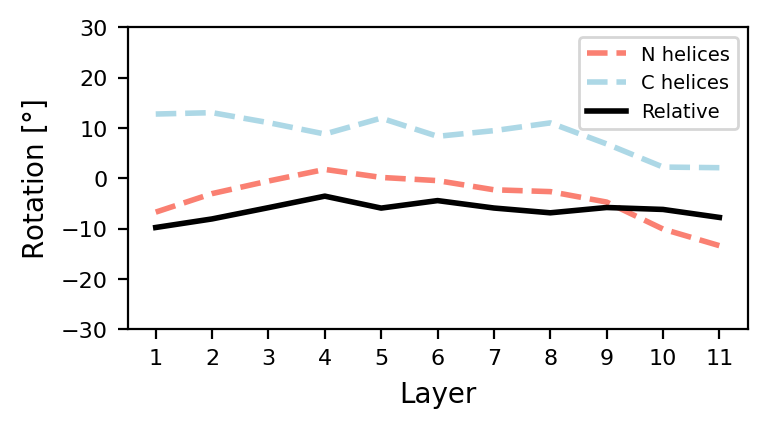

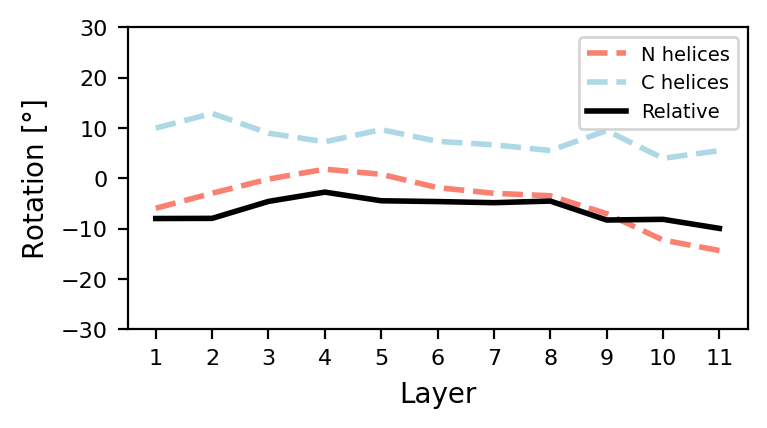

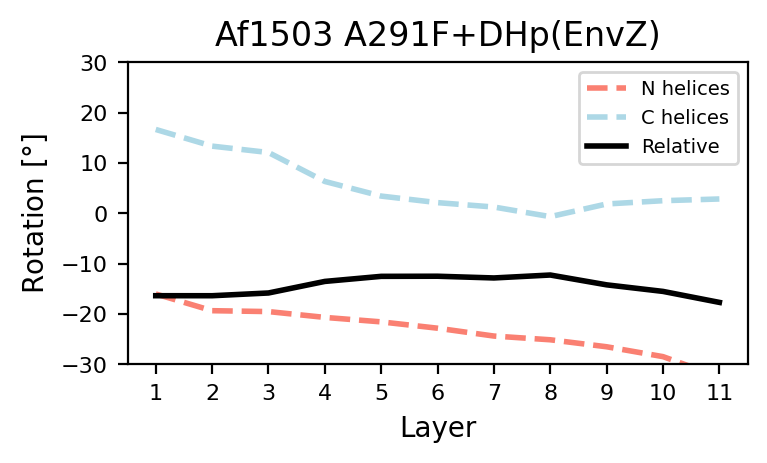

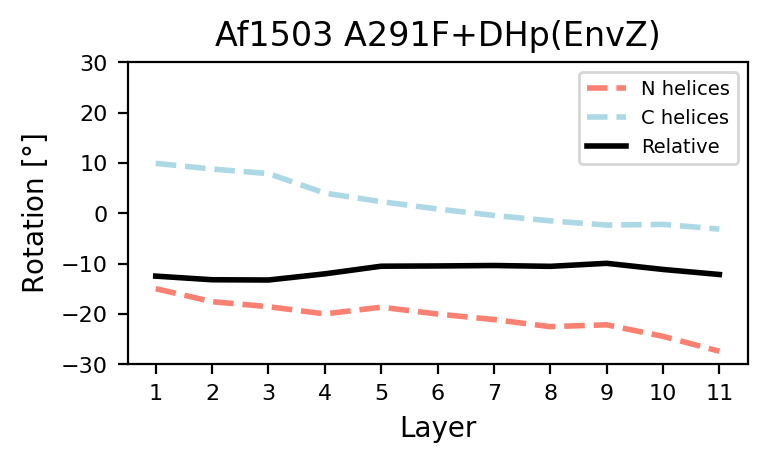

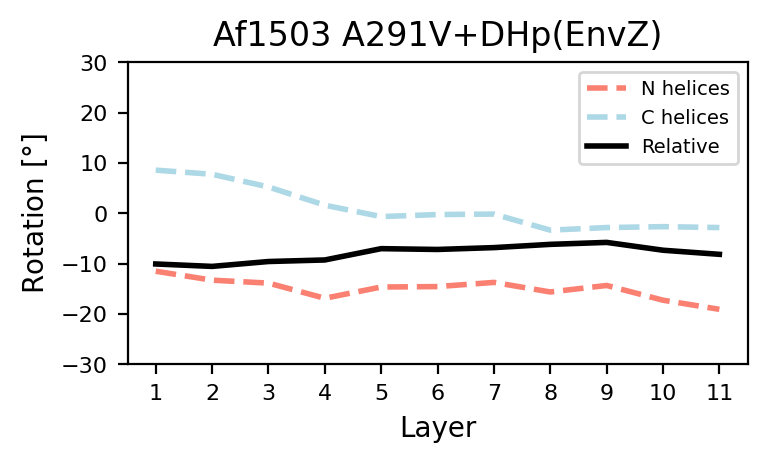

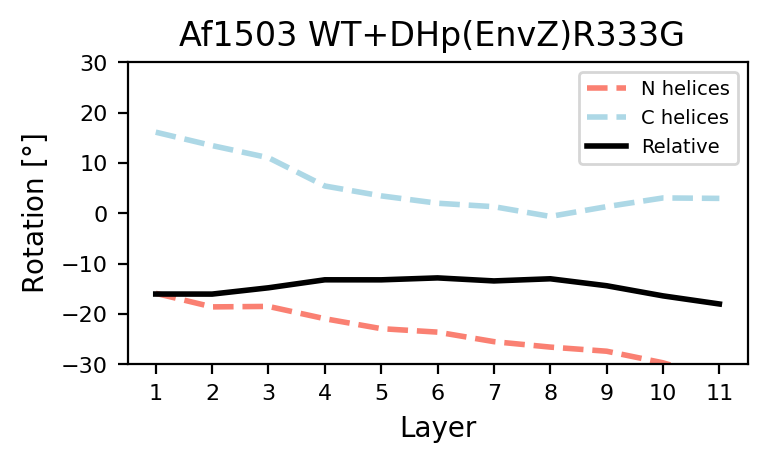

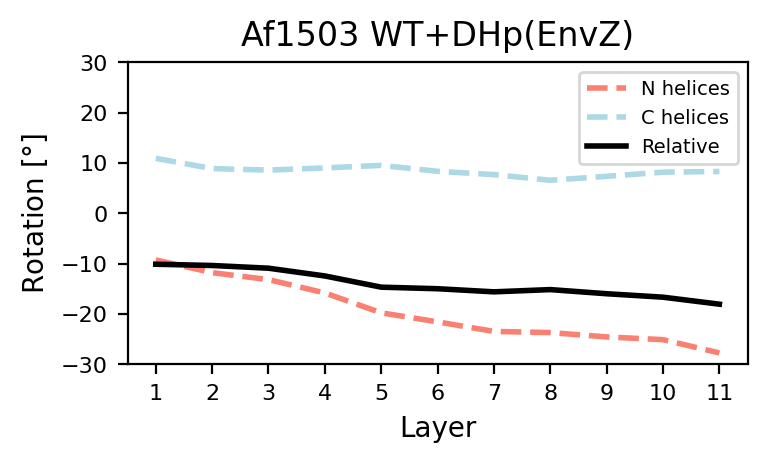

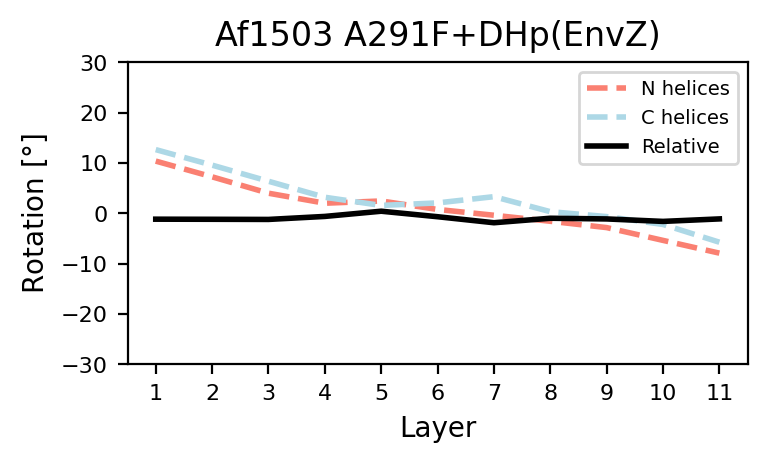

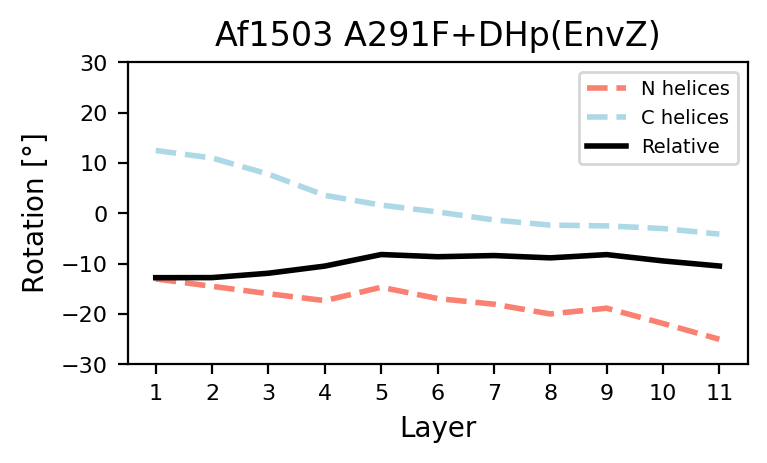

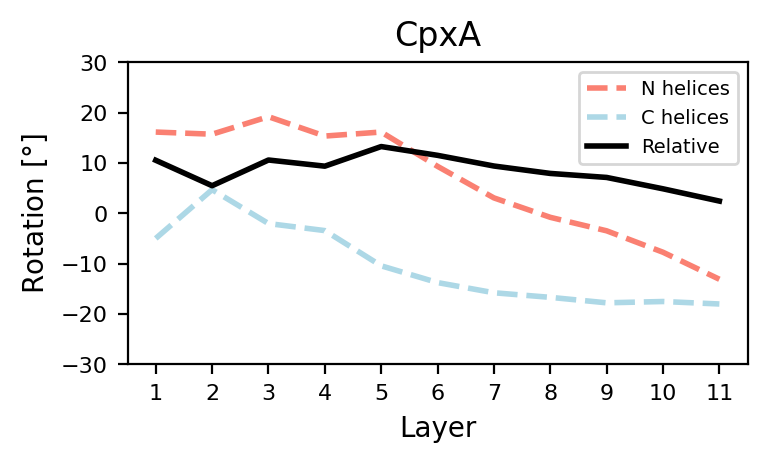

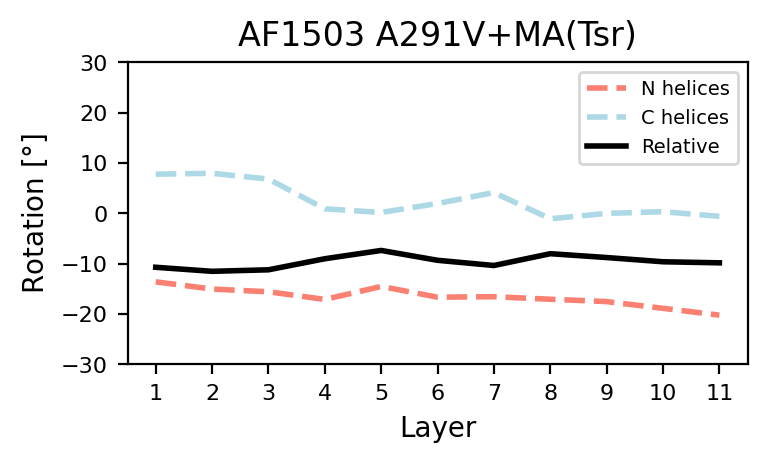

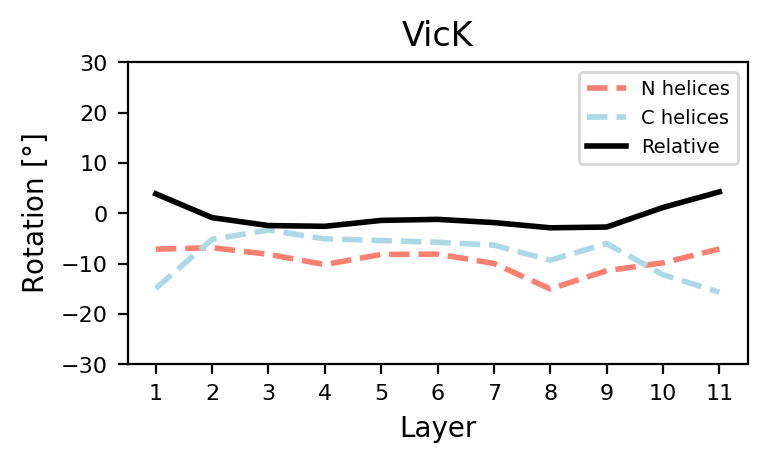

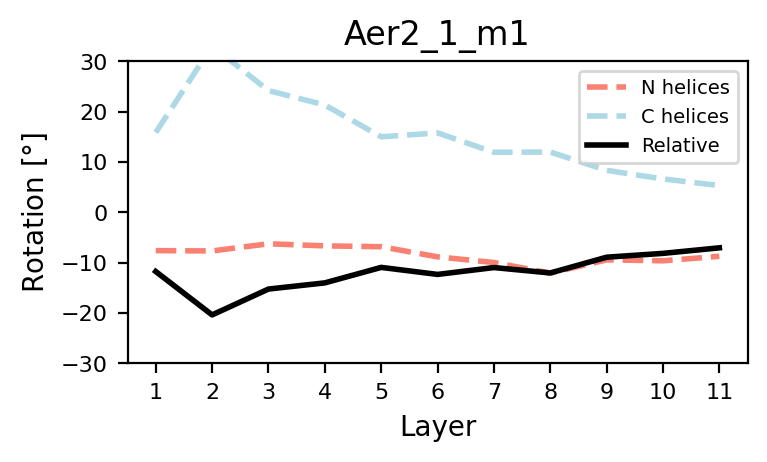

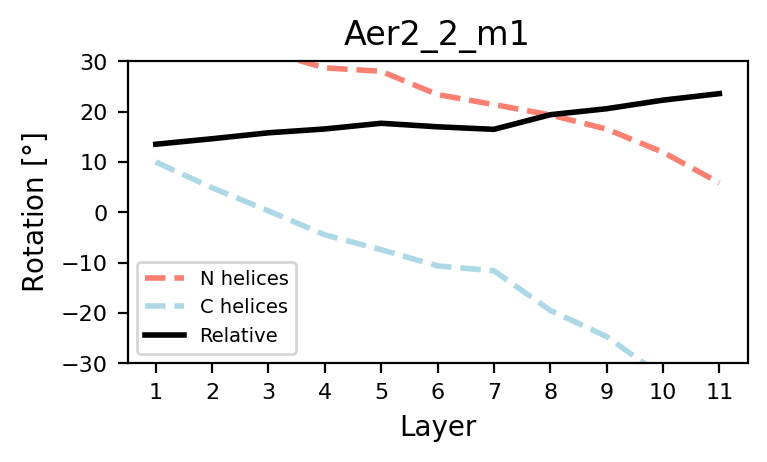

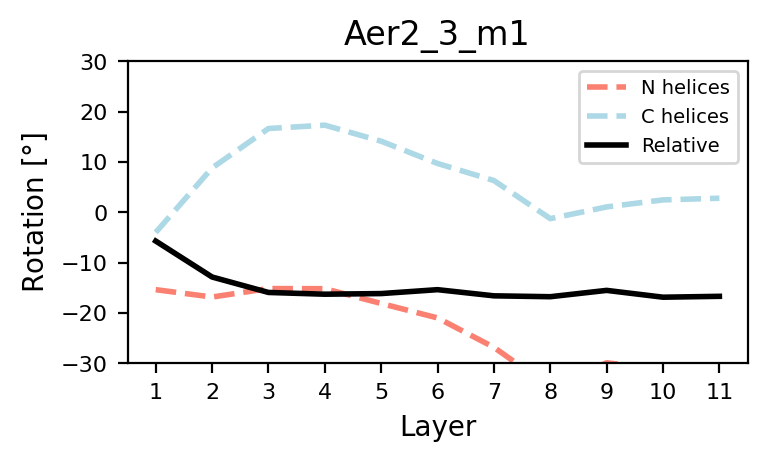

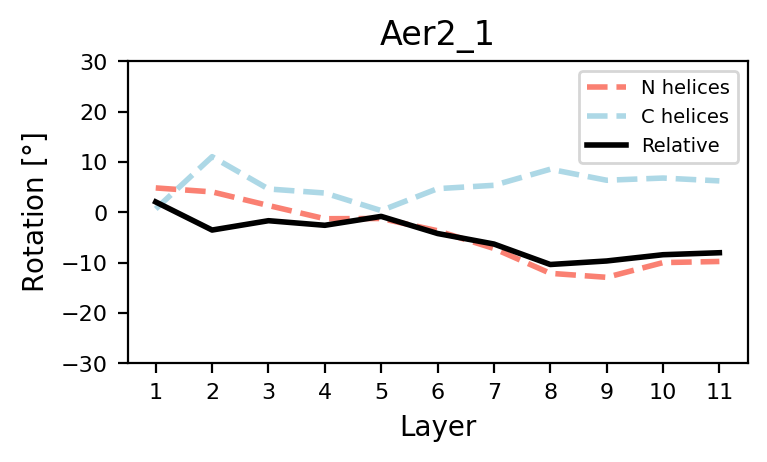

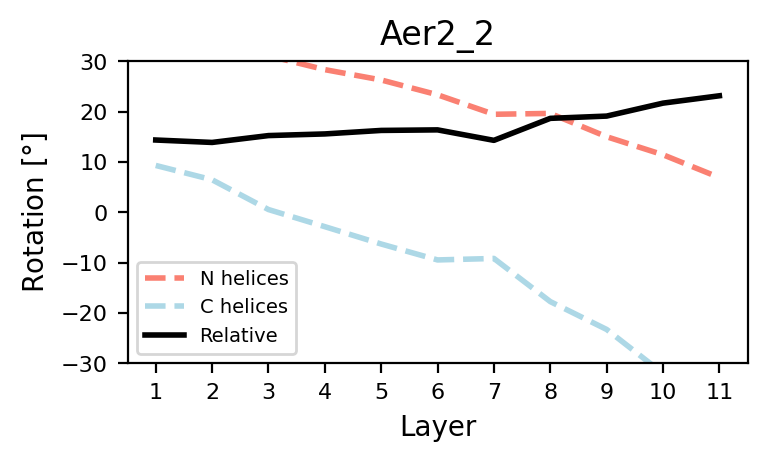

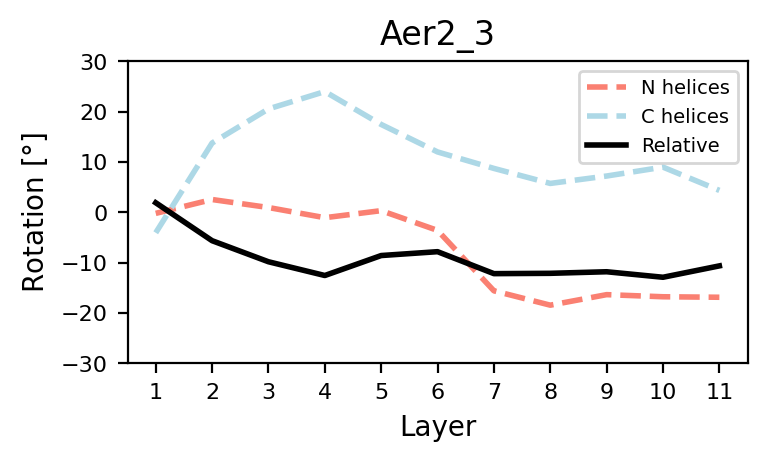

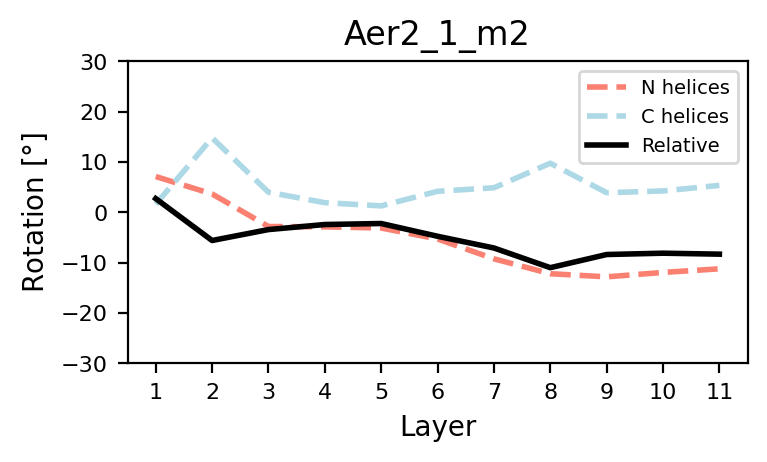

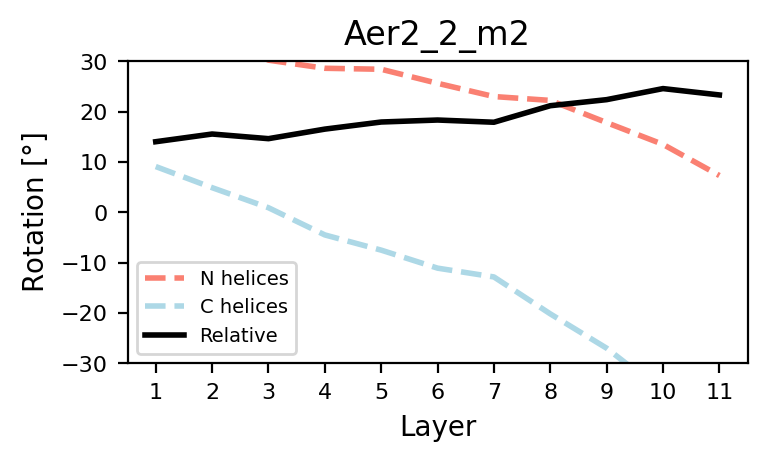

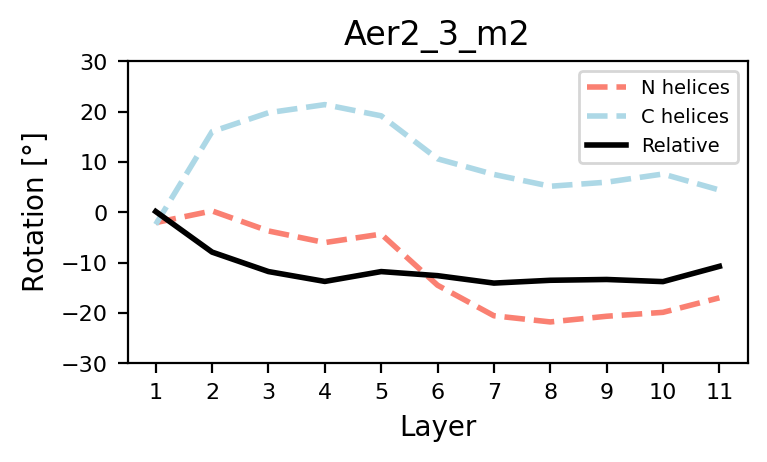

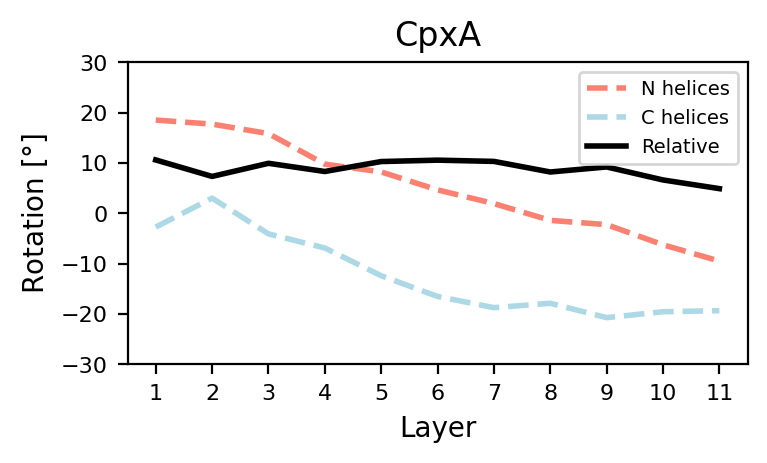

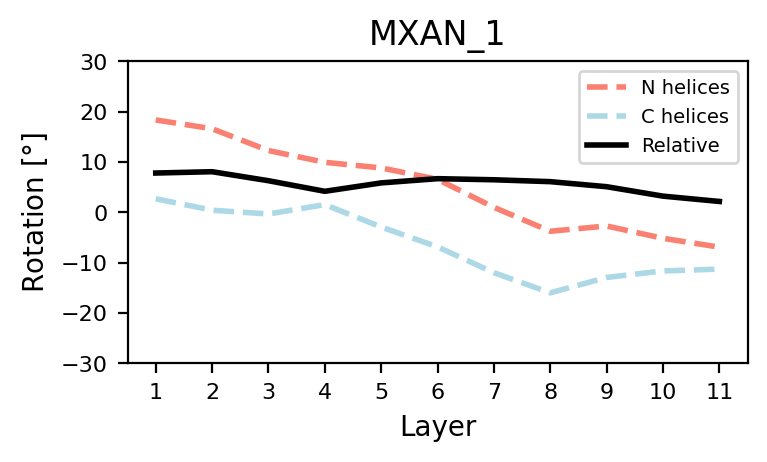

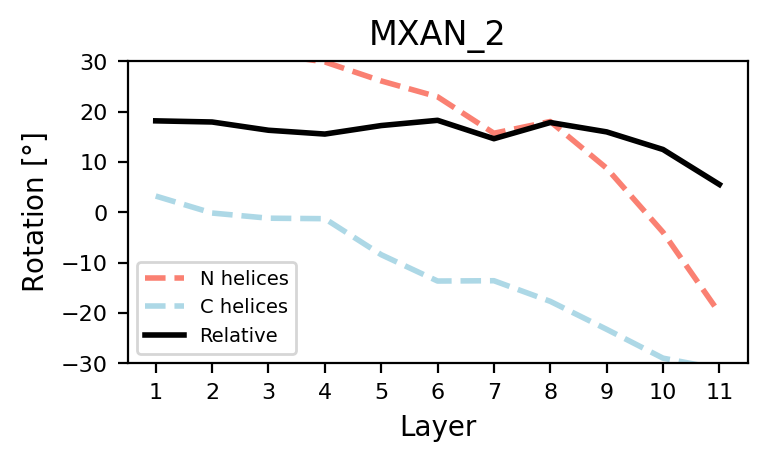

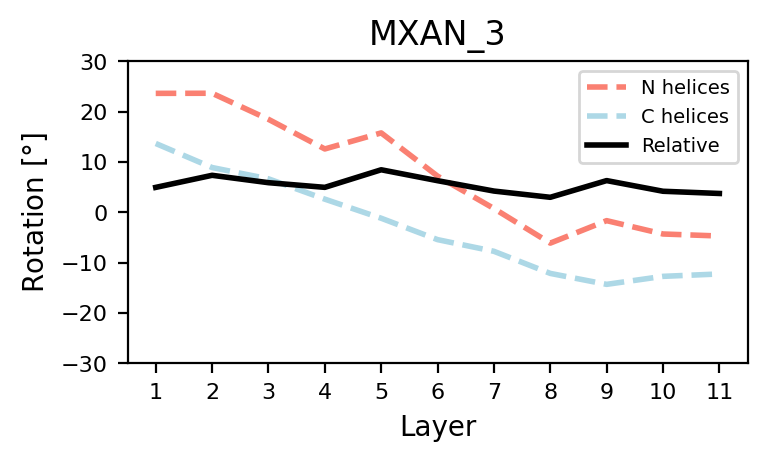

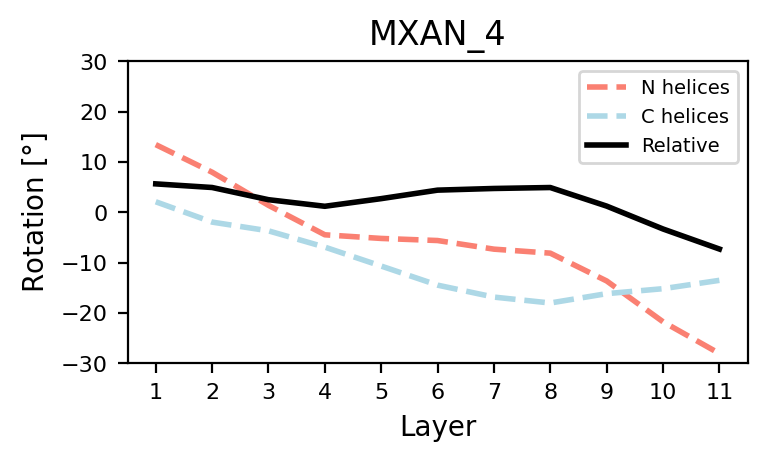

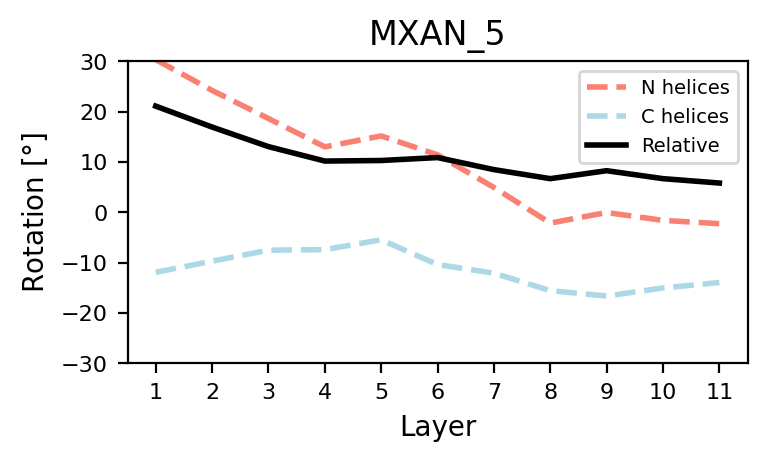

In [10]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

data=[]

for pos, exp_hamp in enumerate(exp_hamps):
    pdb_file = os.path.join(data_dir, 'struct_in', exp_hamp[0])
    
    # excluded structure
    if exp_hamp[-1]==True: continue
    
    # debug:
    #if exp_hamp[-2] != 'Aer2_3_m1': continue
    

    # define measurment ranges
    a1_start = exp_hamp[1]
    a1_stop = a1_start + exp_hamp[3]
    a2_start = exp_hamp[2]
    a2_stop = a2_start + exp_hamp[3] 
    
    chain1 = exp_hamp[4]
    chain2 = exp_hamp[5]
    
    bundle_df, n_crick, c_crick = measure_one_HAMP(pdb_file,
                                                 a1_start, a1_stop,
                                                 a2_start, a2_stop,
                                                 chain1, chain2)

    # cross-shape
    n_radius = bundle_df['radius'][0::2].mean()
    c_radius = bundle_df['radius'][1::2].mean()
    rho = n_radius - c_radius
    
    # axial shift
    n_shift = bundle_df['shift'][0::2].mean()
    c_shift = bundle_df['shift'][1::2].mean()
    glob_shift = (n_shift - c_shift) / 2
    
    # axial rotation
    n_crick = n_crick[2:-2]
    c_crick = c_crick[2:-2]
    
    P = bundle_df.P.values
    n_P_list = P[0::2][2:-2]
    c_P_list = P[1::2][2:-2]
        
    r = bundle_df.P.values
    n_r_list = r[0::2][2:-2]
    c_r_list = r[1::2][2:-2]
        
    n_P = c_P = 3.5
     
    c_phi = n_phi = crangles[exp_hamp[6]] 
    
    n_crick_ref = get_ref_crick(n_P, n_phi)[:len(n_crick)]
    c_crick_ref = get_ref_crick(c_P, c_phi)[:len(c_crick)]
        
    n_crick_diff = diffangle(n_crick, n_crick_ref)
    n_crick_diff = (n_crick_diff[0::2] + n_crick_diff[1::2])/2
    
    c_crick_diff = diffangle(c_crick, c_crick_ref)
    c_crick_diff = (c_crick_diff[0::2] + c_crick_diff[1::2])/2
    
    rot = diffangle(n_crick, c_crick) / 2
    rot = (rot[0::2] + rot[1::2])/2
    
    # plot
    fig, ax = plt.subplots(1,1, figsize=(4, 2), dpi=200)
    
    ax.set_xticks(range(len(n_crick_diff)),
                 labels = [str(i+1) for i in range(len(n_crick_diff))])
    
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
    
    ax.plot(n_crick_diff, label="N helices", lw=2, c='salmon', ls='--')
    ax.plot(c_crick_diff, label="C helices", lw=2, c='lightblue', ls='--')
    ax.plot(rot, label="Relative", lw=2, c='k')
        
    ax.set_ylim(-30, 30)
    ax.set_title(exp_hamp[-2], size=title_font_size)
    
    ax.set_xlabel(r'Layer', size=label_font_size)
    ax.set_ylabel(r'Rotation [$\degree$]', size=label_font_size)  
    
    ax.legend(prop={'size': 7})

        
    # store a new row
    n_crick_diff = np.mean(n_crick_diff)
    c_crick_diff = np.mean(c_crick_diff)
            
    seq1 = bundle_df.res_name[0::4].tolist()
    seq2 = bundle_df.res_name[1::4].tolist()
    seq1 = "".join([AA_3_to_1[res] for res in seq1])
    seq2 = "".join([AA_3_to_1[res] for res in seq2])
    
        
    #print(f'{exp_hamp[0]}\n{a1_start+1} {seq1[1:-1]} {a1_stop-2} {a2_start+1} {seq2[1:-1]} {a2_stop-2}\n\n')
    
    data.append([str(pos)+"_"+exp_hamp[0], n_crick_diff, c_crick_diff, seq1, seq2, exp_hamp[7], n_crick, c_crick, exp_hamp[8],
                exp_hamp[9], glob_shift, rho])
    
    #break
    
    
data_df = pd.DataFrame(data, columns=['pdb', 'n_rot', 'c_rot', 'seq1', 'seq2', 'color', 'n_list', 'c_list', 'label', 'mutant', 'glob_shift','rho'])
data_df.set_index('pdb', inplace=True)

data_df['rot'] = diffangle(data_df.n_list, data_df.c_list) 
data_df['rot_mean'] = data_df['rot'].apply(np.mean)
data_df['rot_std'] = data_df['rot'].apply(np.std)

data_df.to_pickle(os.path.join(data_dir, 'pdb_measure.p'))


In [42]:
data_df

,n_rot,c_rot,seq1,seq2,color,n_list,c_list,label,mutant,glob_shift,rho,rot,rot_mean,rot_std
pdb,,,,,,,,,,,,,,
0_2l7h.pdb,-19.296311,8.163004,PIIELSNTADKIA,EIGILAKSIERLR,lightgrey,"[10.691315672199803, 9.348497498684193, 111.53...","[32.455168941464386, 33.71397672760067, 133.01...",Af1503 WT,False,-0.395336,1.321644,"[-21.763853269264587, -24.365479228916485, -21...",-27.459314,4.259076
1_2l7i.pdb,0.212011,3.933485,PIIELSNTFDKIA,EIGILAKSIERLR,lightgrey,"[30.046690141042358, 29.870238899710994, 129.9...","[31.616712595216924, 31.75597800104769, 132.18...",Af1503 A291F,False,0.496645,1.013614,"[-1.5700224541745627, -1.8857391013366964, -2....",-3.721474,2.435628
2_2y0q.pdb,-17.979150,1.242494,PIIELSNTCDKIA,EIGILAKSIERLR,lightgrey,"[8.749455296510142, 8.332247502951414, 109.794...","[30.54133645838112, 35.05620448184783, 133.773...",Af1503 A291C,False,-0.023741,0.637886,"[-21.791881161870975, -26.72395697889641, -23....",-19.221644,4.166560
3_2y20.pdb,-18.736343,7.062672,PIIELSNTIDKIA,EIGILAKSIERLR,lightgrey,"[4.8490254206099, 7.353972968995644, 105.26845...","[38.23368741211337, 38.50687202988876, 141.637...",Af1503 A291I,False,0.167065,-0.105010,"[-33.384661991503464, -31.152899060893105, -36...",-25.799014,6.038796
4_2y21.pdb,-17.299223,3.459582,PIIELSNTVDKIA,EIGILAKSIERLR,lightgrey,"[7.083678891068137, 7.243731692449341, 108.815...","[31.662792594798677, 30.919029152280665, 134.1...",Af1503 A291V,False,0.173360,-0.175816,"[-24.579113703730542, -23.675297459831313, -25...",-20.758804,3.242909
5_4gn0.pdb,-20.670209,2.709346,PIIELSNTADKIA,EIGILAKSIERLR,lightgrey,"[6.155776443574542, 6.745769181595468, 107.028...","[29.60966001955337, 30.427282065660865, 130.86...",Af1503 WT,False,-0.002860,0.834678,"[-23.453883575978836, -23.6815128840654, -23.8...",-23.379555,3.516682
6_4cq4.pdb,-20.681388,2.730179,PIIELSNTADKIA,EIGILAKSIERLR,lightgrey,"[6.051773838726431, 5.9471775440455446, 107.04...","[29.43714223137992, 30.141579515156362, 133.89...",Af1503 WT,False,0.006044,0.783542,"[-23.385368392653504, -24.194401971110807, -26...",-23.411567,4.156577
7_5iji.pdb,-4.087357,7.779974,PLNQLVTASQRIE,ELGLLAKTFNQMS,lightgrey,"[13.777868219219764, 13.777881762926915, 119.5...","[30.493526849602862, 30.493535314123623, 134.4...",,False,-0.852016,1.828897,"[-16.715658630383103, -16.71565355119671, -14....",-11.867330,3.992330
9_5jef.pdb,4.383736,2.781244,PLNQLVTASQRIE,ELGLLAKTFNQMS,lightgrey,"[16.615564490798363, 16.42797345412655, 123.25...","[26.010083152793875, 30.234989987010515, 131.2...",,False,-1.055980,2.839451,"[-9.394518661995505, -13.80701653288395, -8.01...",1.602492,6.259401


### Compare experimental structures to AF2 models

In [35]:
assert all(data_af2_df.rot.apply(len) == data_df.rot.apply(len))

In [36]:
# define colors
c=[]

for pdbid, pdbrow in data_df.iterrows():
    
    # af1503
    if pdbid in [
        '0_2l7h.pdb', '1_2l7i.pdb', '2_2y0q.pdb', '3_2y20.pdb', '4_2y21.pdb',
        '5_4gn0.pdb', '6_4cq4.pdb', '12_3zrx.pdb', '13_3zrv.pdb',
        '14_3zrw.pdb', '15_3zcc.pdb', '16_2lfr.pdb', '17_2lfs.pdb',
        '18_4cti.pdb', '20_3zx6.pdb'
    ]:
        c.append('#ff0000')
    
    # narq
    elif pdbid in ['7_5iji.pdb', '8_5jeq.pdb', '9_5jef.pdb', '10_5jgp.pdb', '11_6yue.pdb']:
        c.append('#ffd700')
    
    elif pdbid in ['22_4i3m.pdb', '25_3lnr.pdb', '28_4i44.pdb']:
        c.append('#c71585')        
   
    elif pdbid in ['23_4i3m.pdb', '26_3lnr.pdb', '29_4i44.pdb']:
        c.append('#00fa9a')   
        
    elif pdbid in ['24_4i3m.pdb', '27_3lnr.pdb', '30_4i44.pdb']:
        c.append('#0000ff')  
        
    elif pdbid in ['19_4biv.pdb', '31_4biu.pdb']:
        c.append('#1e90ff') 
        
    elif pdbid in ['21_4i5s.pdb']:
        c.append('#ffdab9') 

    else:
        c.append('#000000') 
        #raise ValueError

In [37]:
# calculate global rotation index
def get_labels(df):
    a = np.vstack(df['rot'].values)
    return ((a[:,0::2] + a[:,1::2]) / 2).mean(axis=1) / 2

Text(0.5, 1.0, 'AlphaFold2')

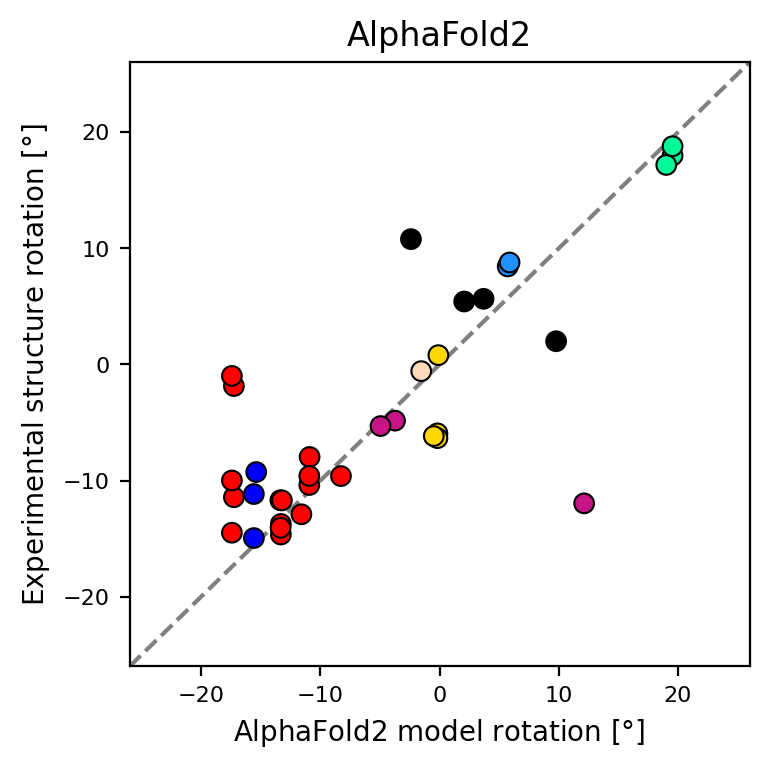

In [38]:
# rotation 
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)

rot_af2 = get_labels(data_af2_df[~data_af2_df.mutant])
rot_pdb = get_labels(data_df[~data_df.mutant])

#colors = ['white' if i>8 else 'grey' for i in np.abs(rot_af2 - rot_pdb)]

ax.scatter(rot_af2, rot_pdb, c=c, lw=0.75, edgecolors='k', s=50)    

ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey', zorder=0)
ax.set_xlabel(r'AlphaFold2 model rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)
ax.set_title("AlphaFold2", size=title_font_size)


In [40]:
header = f"{'PDB':<20}{'Isolated AF2':<20}{'PDB':<20}"
print(header)
print("="*len(header))

for pdb, rot_af2, rot_pdb in zip(data_df[~data_df.mutant].index, get_labels(data_af2_df[~data_af2_df.mutant]),
                                 get_labels(data_df[~data_df.mutant])):
    #if abs(rot_pdb-rot_af2)>8:
        #print(pdb, rot_af2, rot_pdb) #, rot_pdb-rot_af2)
        print(f"{pdb:<20}{np.round(rot_af2,1):<20}{np.round(rot_pdb,1):<20}")
        


PDB                 Isolated AF2        PDB                 
0_2l7h.pdb          -13.3               -13.7               
1_2l7i.pdb          -17.2               -1.9                
2_2y0q.pdb          -8.3                -9.6                
3_2y20.pdb          -11.6               -12.9               
4_2y21.pdb          -10.9               -10.4               
5_4gn0.pdb          -13.4               -11.7               
6_4cq4.pdb          -13.2               -11.7               
7_5iji.pdb          -0.2                -5.9                
9_5jef.pdb          -0.1                0.8                 
10_5jgp.pdb         -0.2                -6.3                
11_6yue.pdb         -0.5                -6.2                
12_3zrx.pdb         -17.4               -14.5               
13_3zrv.pdb         -17.2               -11.4               
14_3zrw.pdb         -10.9               -8.0                
15_3zcc.pdb         -13.3               -14.6               
16_2lfr.pdb         -13.

### Shift

Text(0.5, 1.0, 'AlphaFold2')

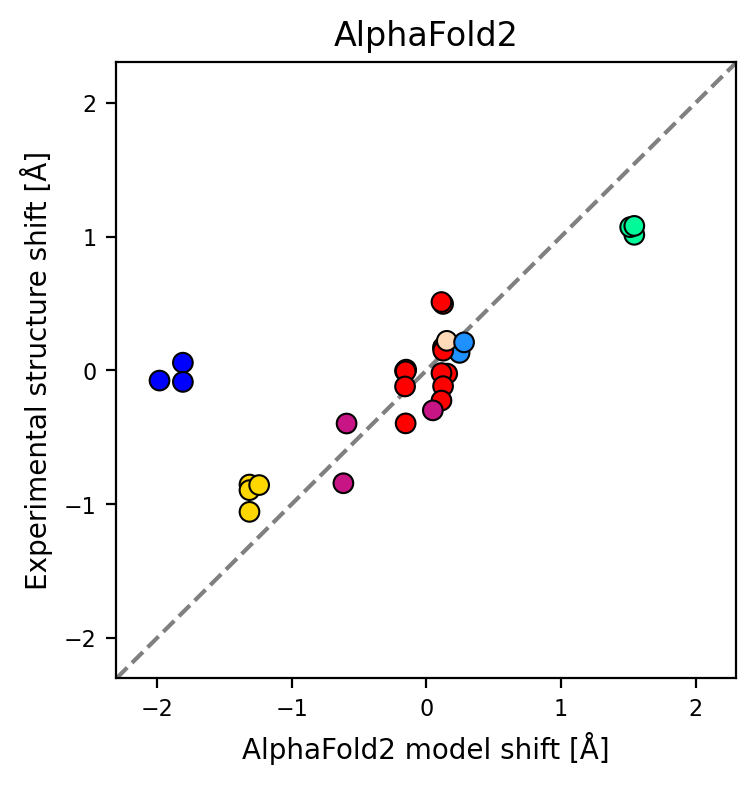

In [64]:
# shift

# rotation 
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)
ax.set_ylim(-2.3, 2.3)
ax.set_xlim(-2.3, 2.3)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)

rot_af2 = data_af2_df[~data_af2_df.mutant].glob_shift
rot_pdb = data_df[~data_df.mutant].glob_shift

#colors = ['white' if i>1 else 'grey' for i in np.abs(rot_af2 - rot_pdb)]

ax.scatter(rot_af2, rot_pdb, c=c, lw=0.75, edgecolors='k', s=50)    

ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey', zorder=0)
ax.set_xlabel(r'AlphaFold2 model shift [Å]', size=label_font_size)
ax.set_ylabel(r'Experimental structure shift [Å]', size=label_font_size)
ax.set_title("AlphaFold2", size=title_font_size)


In [82]:
# list structures where shift was not predicted correctly
for pdb, rot_af2, rot_pdb in zip(data_df[~data_df.mutant].index, data_af2_df[~data_af2_df.mutant].glob_shift,
                                 data_df[~data_df.mutant].glob_shift):
    #print (rot_pdb,rot_af2)
    if abs(rot_pdb-rot_af2)>1:
        print(pdb, rot_af2, rot_pdb, rot_pdb-rot_af2)

24_4i3m.pdb -1.8060237816899312 0.058002967787653265 1.8640267494775844
27_3lnr.pdb -1.9793757776770158 -0.0756208850764174 1.9037548926005985
30_4i44.pdb -1.8060237816899312 -0.08561783963269583 1.7204059420572353


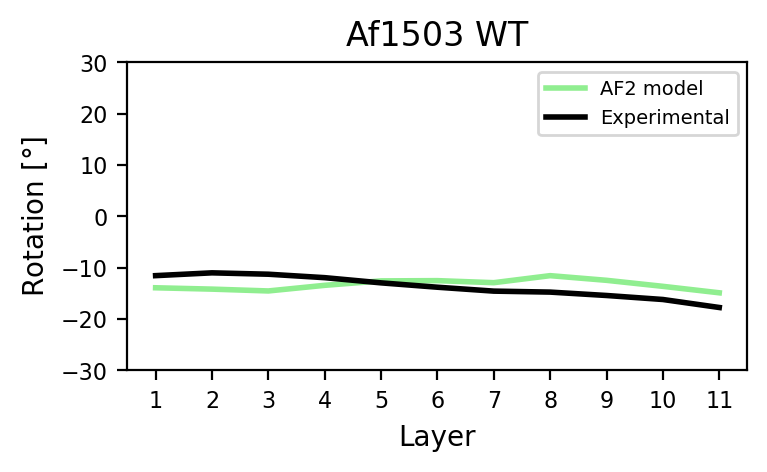

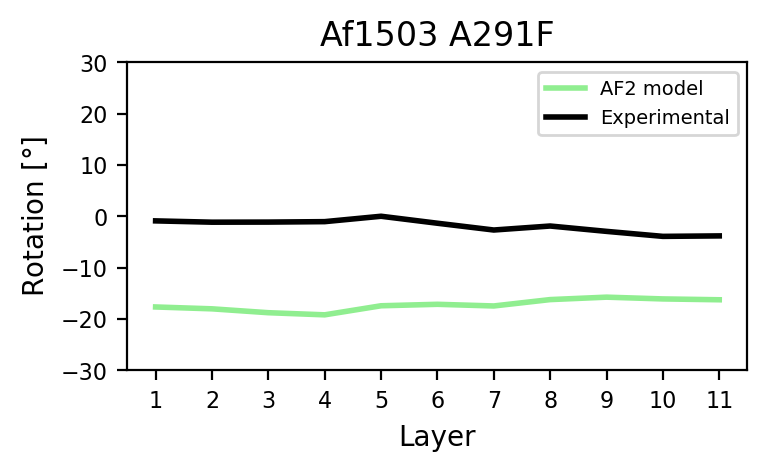

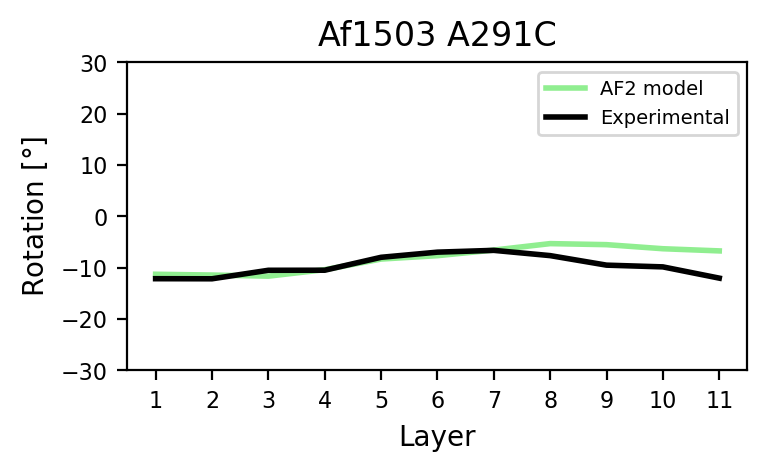

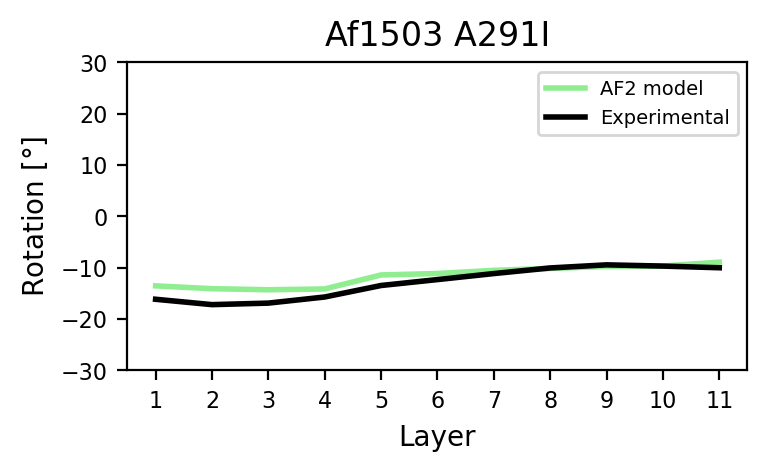

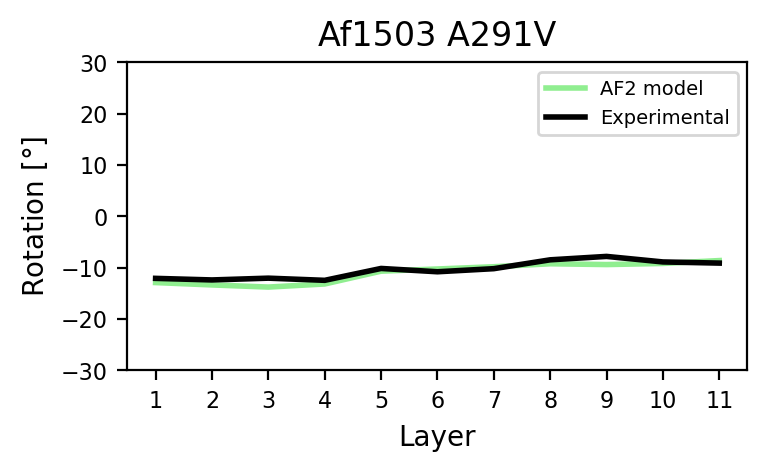

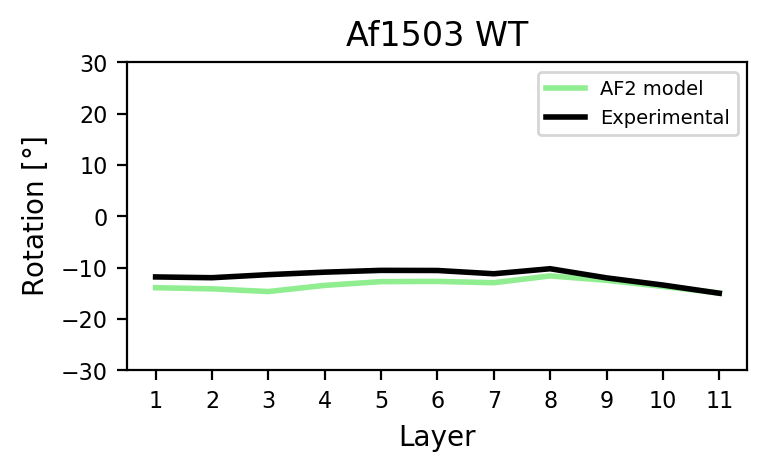

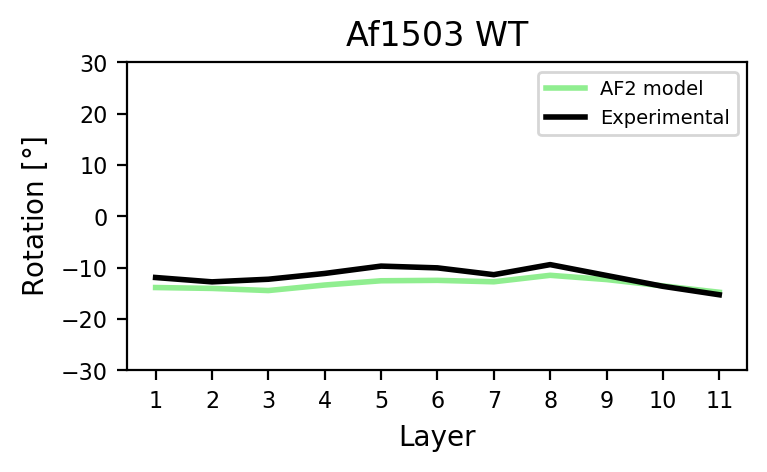

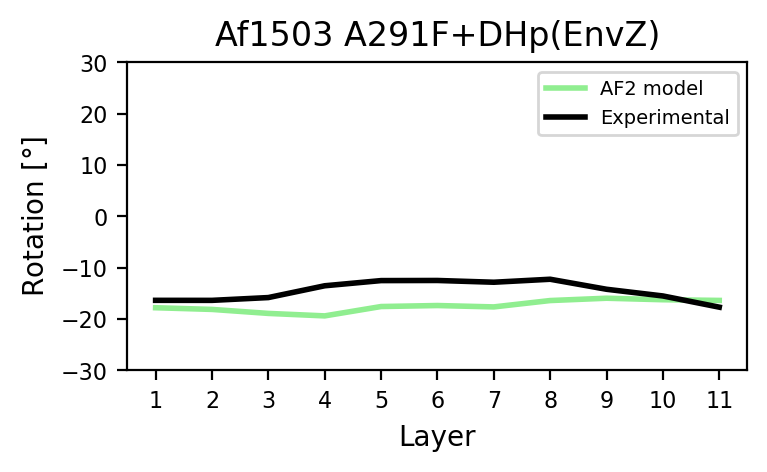

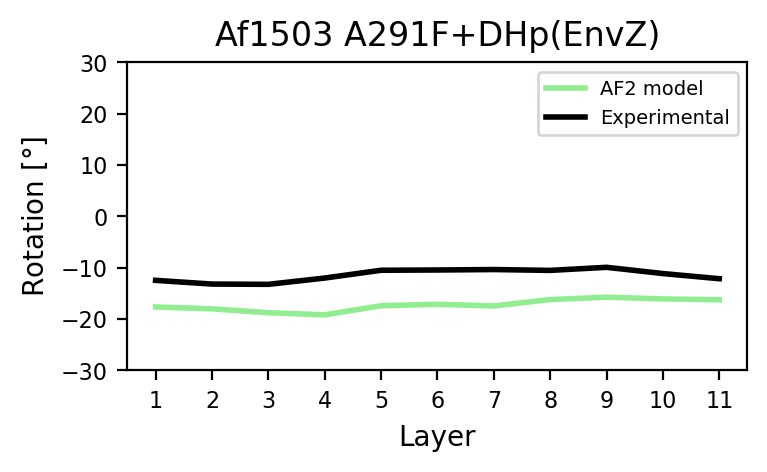

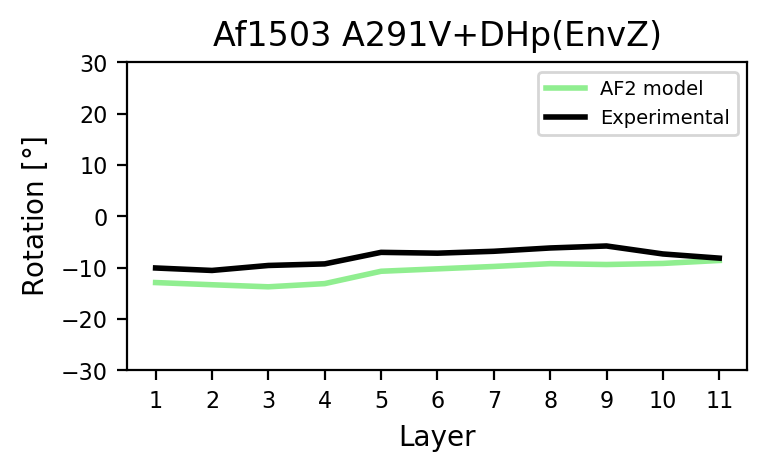

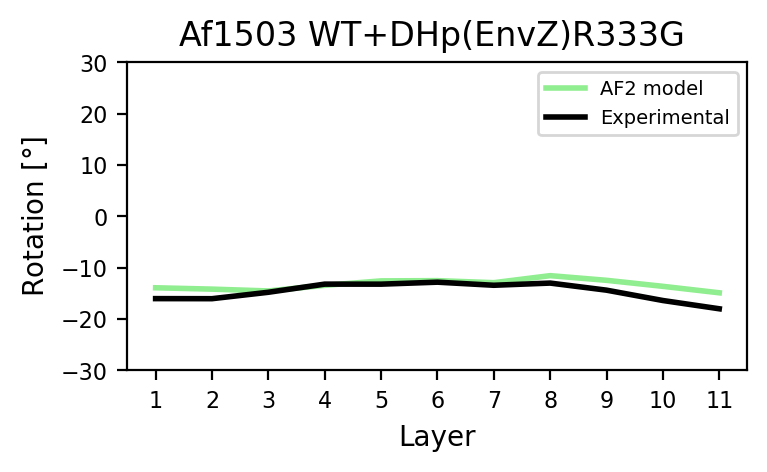

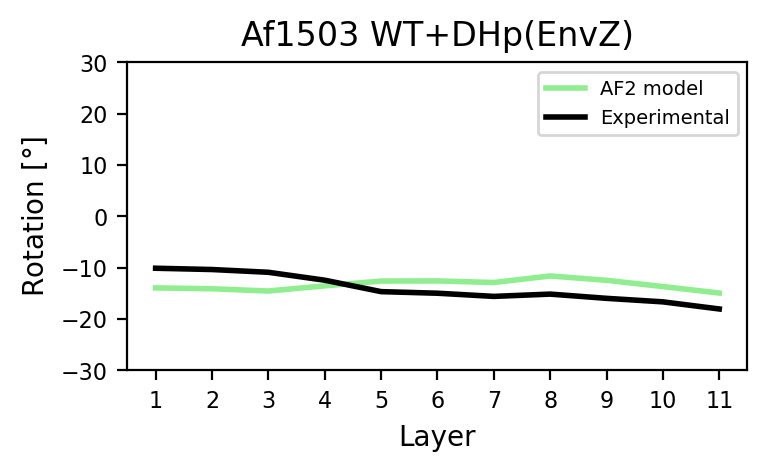

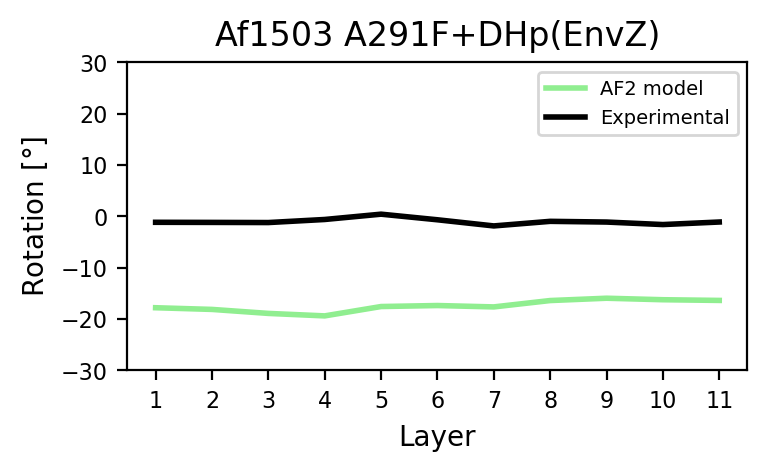

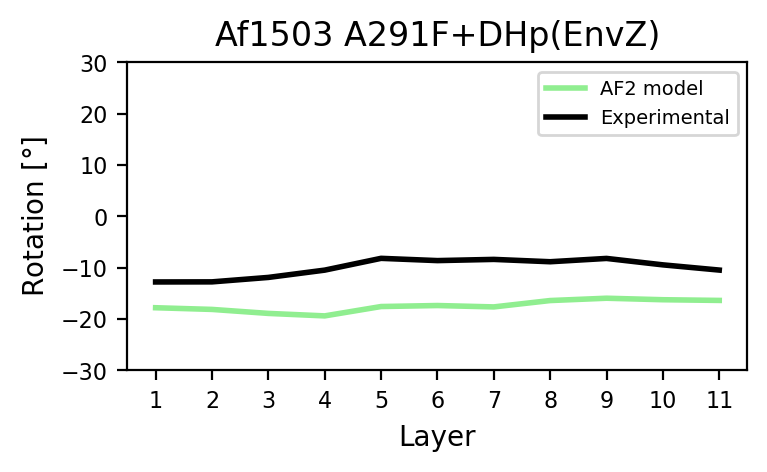

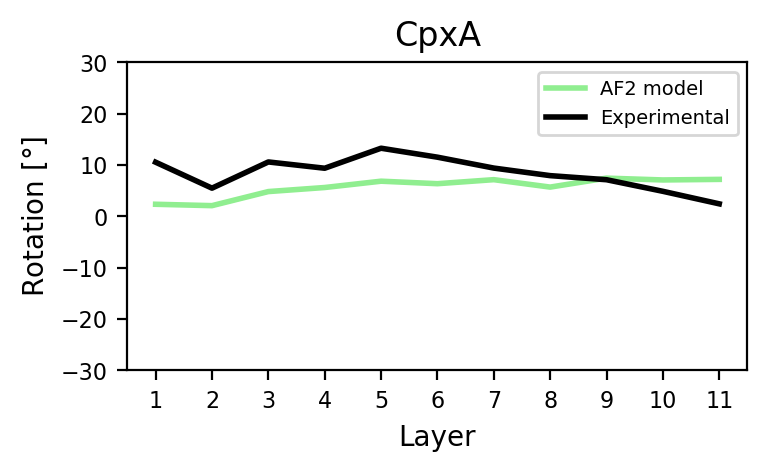

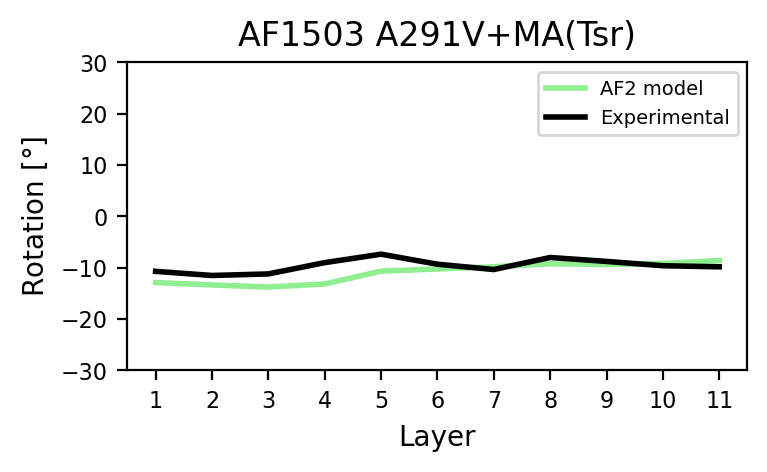

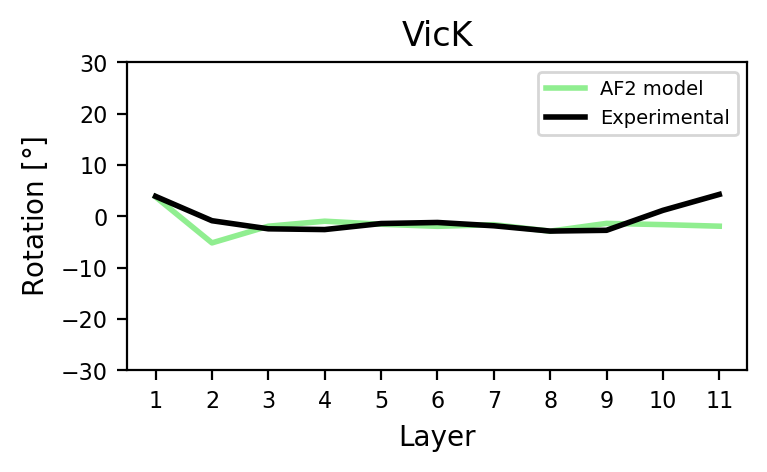

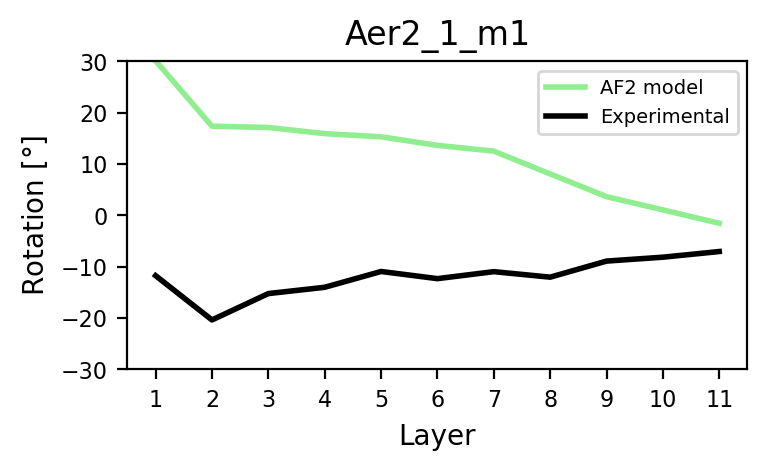

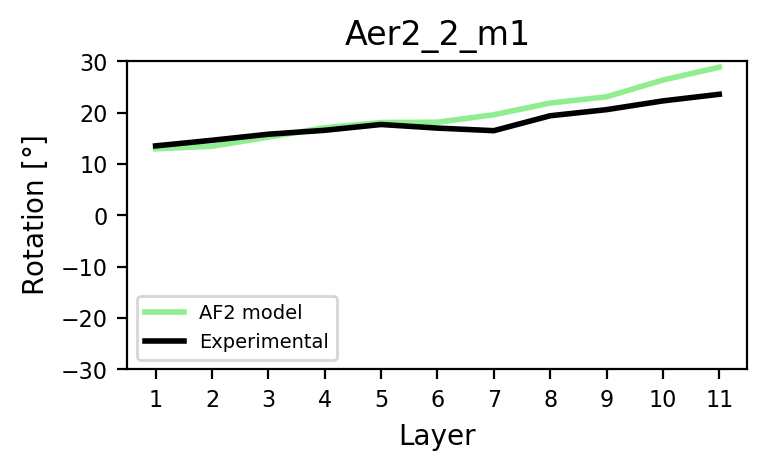

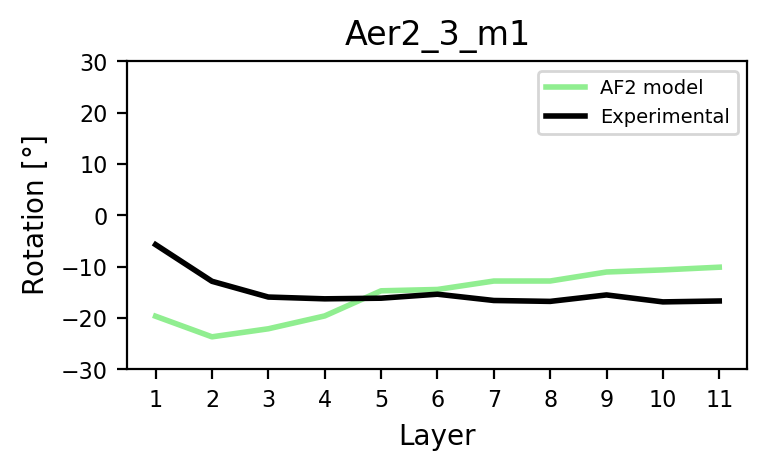

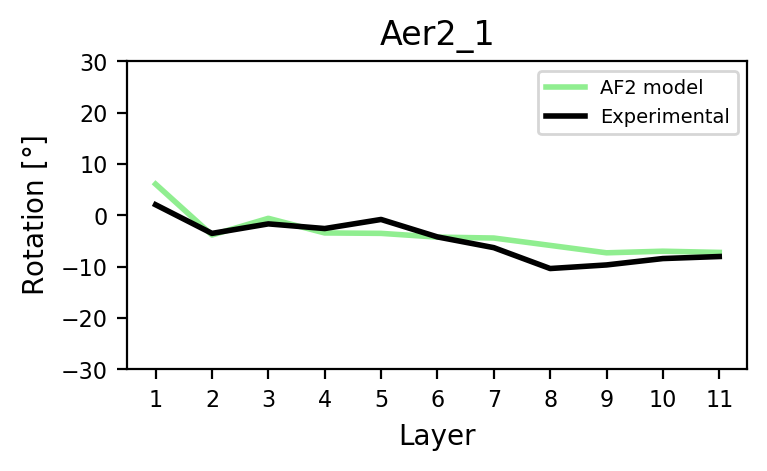

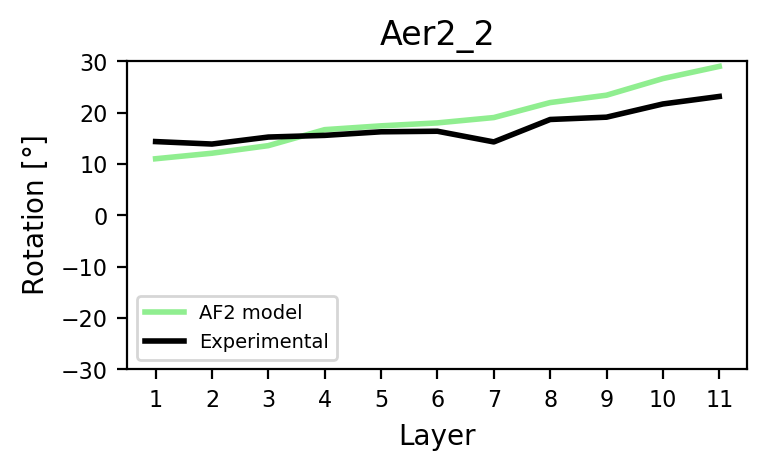

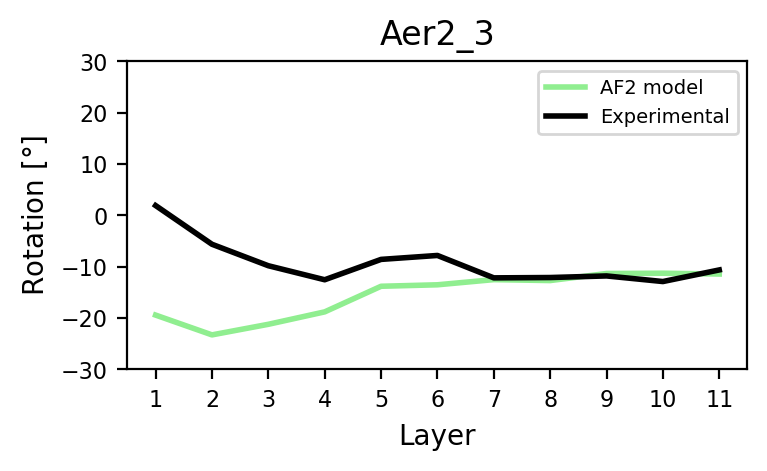

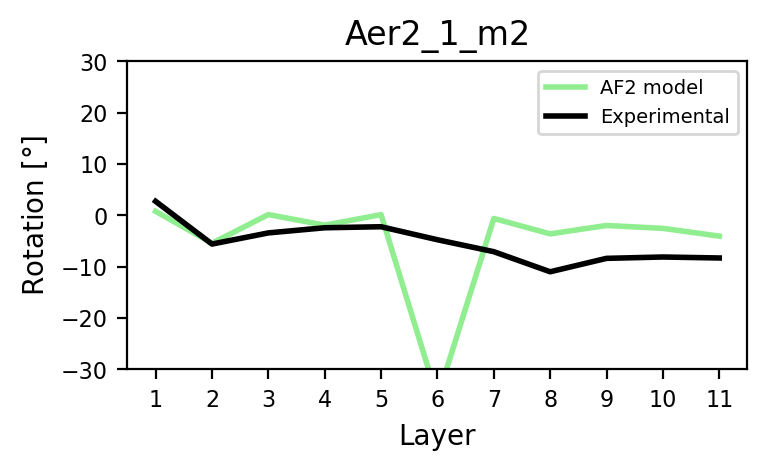

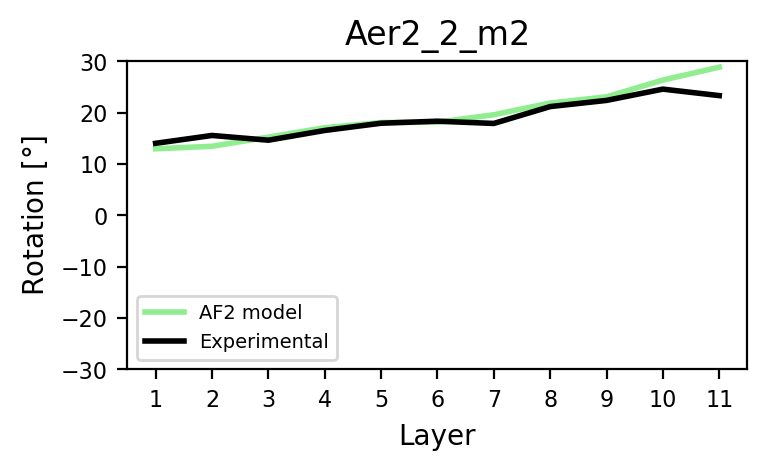

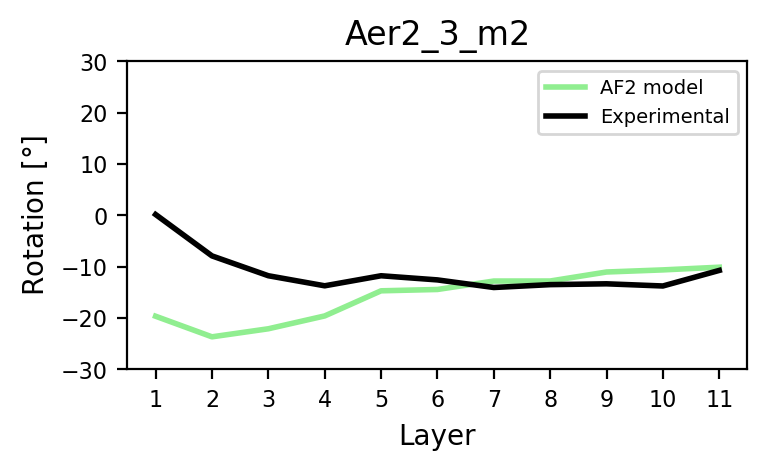

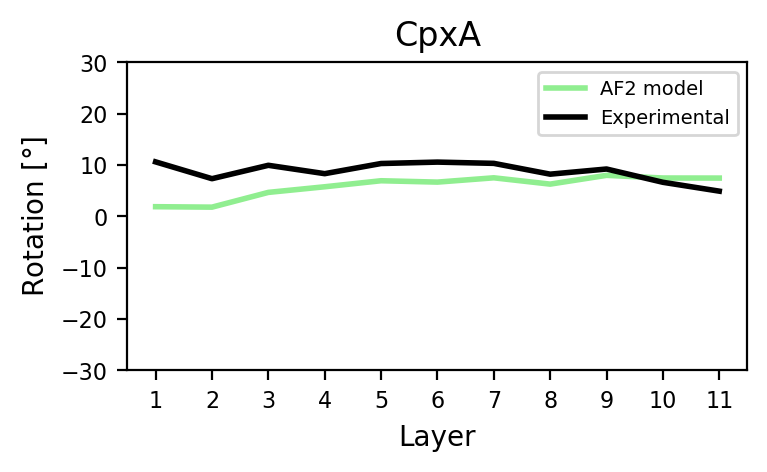

In [28]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

for pos, (pdb, af2_row) in enumerate(data_af2_df.iterrows()):
    
    #ident = str(pos)+"_"+pdb
    ident = pdb
    # no included
    if af2_row.mutant: continue
    
    # no description
    if exp_hamp2name[ident]=="": continue
                
    af2_rot = (af2_row.rot[0::2] + af2_row.rot[1::2])/4
    pdb_row = data_df.loc[ident]   
    pdb_rot = (pdb_row.rot[0::2] + pdb_row.rot[1::2])/4

    # plot
    fig, ax = plt.subplots(1,1, figsize=(4, 2), dpi=200)

    ax.set_xticks(range(len(pdb_rot)),
                 labels = [str(i+1) for i in range(len(pdb_rot))])
    
    ax.set_ylim(-30, 30)
    
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
    
    ax.plot(af2_rot, lw=2, label='AF2 model', c='lightgreen')
    ax.plot(pdb_rot, lw=2, label='Experimental', c='k')
    
    ax.set_xlabel(r'Layer', size=label_font_size)
    ax.set_ylabel(r'Rotation [$\degree$]', size=label_font_size)
        
    ax.set_title(exp_hamp2name[ident], size=title_font_size)
    
    ax.legend(prop={'size': 7})
    
    

### Compare shift and rotation in experimental structures

Text(0, 0.5, 'Helix axial rotation [$\\degree$]')

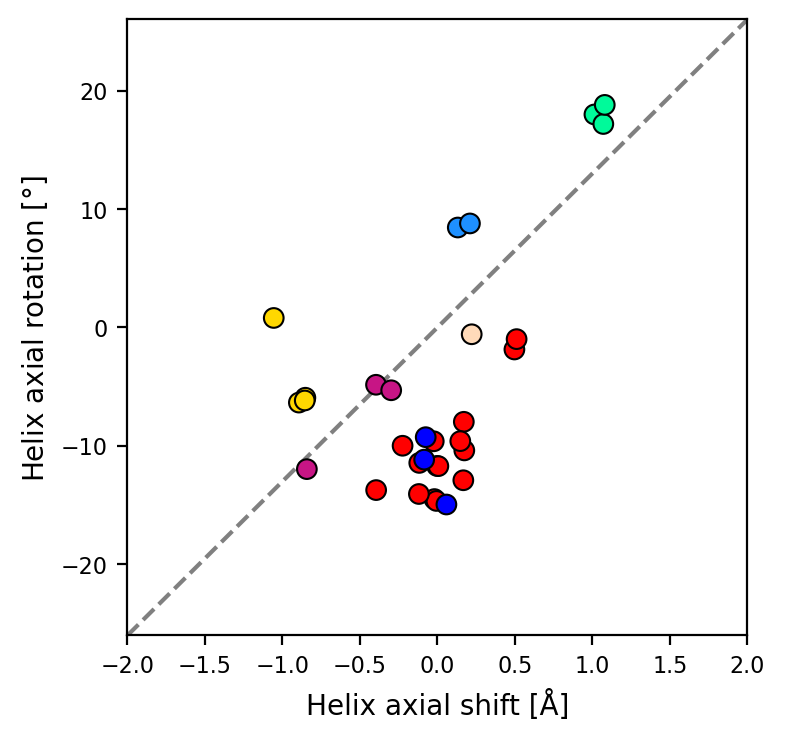

In [62]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)
ax.set_ylim(-26, 26)
ax.set_xlim(-2, 2)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)

rot_pdb = get_labels(data_df[~data_df.mutant])
shift_pdb = data_df[~data_df.mutant].glob_shift

ax.scatter(shift_pdb, rot_pdb, c=c, lw=0.75, edgecolors='k', s=50)    

ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey', zorder=0)
ax.set_xlabel(r'Helix axial shift [Å]', size=label_font_size)
ax.set_ylabel(r'Helix axial rotation [$\degree$]', size=label_font_size)


In [63]:
import numpy as np

# Assuming rot_pdb and shift_pdb are your data lists/arrays
correlation_matrix = np.corrcoef(rot_pdb, shift_pdb)

# The correlation coefficient is at index [0, 1] in the correlation matrix
correlation_coefficient = correlation_matrix[0, 1]

print("Correlation Coefficient:", correlation_coefficient)


Correlation Coefficient: 0.5591899801149612


<AxesSubplot: >

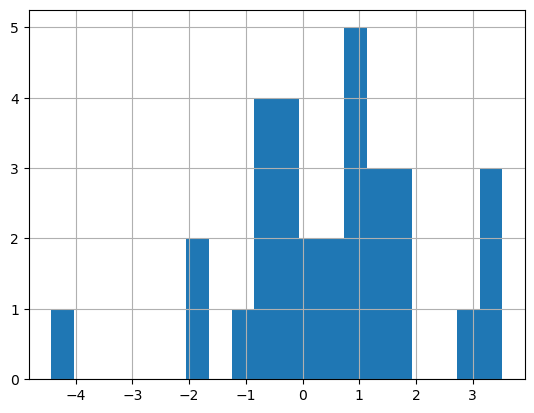

In [75]:
data_df.rho.hist(bins=20)